In [1]:
import pandas as pd
from tqdm import tqdm
import pickle
import argparse
import json
import os

import torch
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit.Chem import AllChem
from ase import Atoms
from ase.io import read
from ase.io.jsonio import encode, decode
from ase.optimize import BFGS

from orb_models.forcefield import pretrained
from orb_models.forcefield.calculator import ORBCalculator

from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import argparse
import json

import torch
from torch.utils.data import Dataset

from rdkit import Chem
from rdkit.Chem import AllChem
from ase import Atoms
from ase.io.jsonio import encode, decode
from ase.optimize import BFGS

from orb_models.forcefield import atomic_system, pretrained
from orb_models.forcefield.calculator import ORBCalculator

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error, r2_score, mean_squared_error

/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
curr_dir = 'data/pnas'

# Chemical dictionary
chem_name = pd.read_csv(os.path.join(curr_dir, 'names.csv'))    
ri = pd.read_excel(os.path.join(curr_dir, 'Electrolyte dataset.xlsx'), sheet_name='Reagent information')
chem_dict = dict(zip(ri['Representative Abbreviation'], ri['SMILES']))#dict(zip(chem_name['abbreviation'], chem_name['CanonicalSMILES']))

# # Experimental data
# exp = pd.read_excel(os.path.join(curr_dir, 'Electrolyte dataset.xlsx'), sheet_name='Experimental condictions')
# # drop na according to the solvent 
# exp[exp['Unnamed: 52'] == '#DIV/0!'] = np.nan  # Column BA in the table
# exp = exp.dropna(subset=['Unnamed: 52'])

# # Literature data
# lit = pd.read_excel(os.path.join(curr_dir, 'Literature dataset.xlsx'), sheet_name='Battery performance_new')
# # drop na according to the solvent
# lit = lit.dropna(subset=['CE (%)'])
# lit = lit[lit['CE (%)']!='/']

# PNAS data
pnas = pd.read_excel(os.path.join(curr_dir, 'pnas.2214357120.sd01.xlsx'), sheet_name='Dataset')
# drop na according to the solvent
pnas = pnas.dropna(subset=['Unnamed: 27', 'Solvent'])

In [3]:

from utils import (
    pubchem_request, 
    converting, 
    parse_additive, 
    parse_solvent, 
    parse_salt, 
    parse_experiment,
    y_converter,
    y_converter_inverse,
    calculate_molecular_weight
)


def smiles_to_ase(smiles, conformation=False):
    """
    Convert a SMILES string into a 3D ASE Atoms object using RDKit.
    """
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Could not parse SMILES string: {smiles}")
    
    # Add hydrogen atoms
    mol = Chem.AddHs(mol)
    
    if conformation:
        # Generate a 3D conformation using ETKDG_v3
        AllChem.EmbedMolecule(mol, maxAttempts=10)
        AllChem.UFFOptimizeMolecule(mol, maxIters=100)
    else:
        # Generate a 2D conformation
        AllChem.Compute2DCoords(mol)
    
    # Extract atomic positions from the RDKit conformer
    conformer = mol.GetConformer()
    positions = []
    symbols = []
    for atom in mol.GetAtoms():
        pos = conformer.GetAtomPosition(atom.GetIdx())
        positions.append((pos.x, pos.y, pos.z))
        symbols.append(atom.GetSymbol())
    
    # Create an ASE Atoms object
    ase_atoms = Atoms(symbols=symbols, positions=positions)
    return ase_atoms


def get_graph_features(atoms, model, layer_until, device):
    """
    Get the graph features from the model until the specified layer.
    
    Args:
    - atoms (dict): Dictionary containing the atomic coordinates and atomic numbers.
    - model (OrbFrozenMLP): The model to extract the features from.
    - layer_until (int): The layer until which the features are extracted. (1-15)
    - device (str): The device to run the model on.
    
    Returns:
    - np.ndarray: The graph features.
    """
    graph = atomic_system.ase_atoms_to_atom_graphs(atoms, device=device)
    graph = model.featurize_edges(graph)
    graph = model.featurize_nodes(graph)
    graph = model._encoder(graph)

    for gnn in model.gnn_stacks[:layer_until]:
        graph = gnn(graph)
    
    graph = model._decoder(graph)
    return graph.node_features['feat'].mean(dim=0).cpu().numpy()

In [4]:
exp_parsed = []
for i, row in pnas.iterrows():
    # if i != 0:  # dummy row exists in the first row
        # try:
            # print(row['Solvent'], row['Salt'], row['Additive(s)'])
            exp_parsed.append({'exp':parse_experiment(row['Solvent'], row['Salt'], row['Additive(s)'], chem_dict, ri), 
                               'CE':row['Unnamed: 27']})
        # except Exception as e:
        #     print(i)
        #     print(row['Solvent'], row['Salt'], row['Additive(s)'])

In [5]:
device = 'cuda:0'
property_cols = ['CE']
orbff = pretrained.orb_v2(device=device)
calc = ORBCalculator(orbff, device=device)
layer = 16
split_type = 'random'
task_type = 'regression'
log_transform = False

/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

GPU tensorfloat matmuls precision set to 'high'. This can achieve up to 2x speedup on Nvidia A100 and H100 devices.


In [6]:
def exp_features_concent(exp, conformation, concentration_type, model, layer, device):
    """
    Extract features from the experimental data.
    """
    exp_feats = []
    for smi, concent in exp.items():
        atoms = smiles_to_ase(smi, conformation=conformation)
        feat = get_graph_features(atoms, model, layer, device) 
        exp_feats.append((feat, concent[concentration_type]))
    exp_feat = np.sum([feat*concent for feat, concent in exp_feats], axis=0)
    return exp_feat


def random_split(dataset_X, dataset_Y, random_seed, valid_size=0, test_size=0.1):
    import random
    random.seed(random_seed)

    indices = list(range(len(dataset_X)))
    random.shuffle(indices)
    valid_cutoff = int(len(dataset_X) * valid_size)
    test_cutoff = int(len(dataset_X) * test_size)
    
    valid_indices = indices[:valid_cutoff]
    test_indices = indices[valid_cutoff:valid_cutoff + test_cutoff]
    train_indices = indices[valid_cutoff + test_cutoff:]
    
    train_X, train_Y = dataset_X[train_indices], dataset_Y[train_indices]
    valid_X, valid_Y = dataset_X[valid_indices], dataset_Y[valid_indices]
    test_X, test_Y = dataset_X[test_indices], dataset_Y[test_indices]

    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y

def scaffold_split(dataset_X, dataset_Y, smiles_list, random_seed, valid_size=0, test_size=0.1):
    if smiles_list is None:
        raise ValueError("smiles_list is required for scaffold splitting.")
    import random
    import numpy as np
    from rdkit import Chem
    from rdkit.Chem.Scaffolds import MurckoScaffold
    
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    def generate_scaffold(mol, include_chirality=True):
        return MurckoScaffold.MurckoScaffoldSmiles(
            mol=mol,
            includeChirality=include_chirality
        )

    scaffolds = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        scaf = generate_scaffold(mol) if mol is not None else smi
        scaffolds.append(scaf)
    
    scaffold_to_indices = {}
    for idx, scaf in enumerate(scaffolds):
        scaffold_to_indices.setdefault(scaf, []).append(idx)
    
    # Sort by descending frequency
    scaffolds_sorted = sorted(scaffold_to_indices.keys(), key=lambda x: len(scaffold_to_indices[x]), reverse=True)
    
    total_size = len(dataset_X)
    valid_cutoff = int(np.floor(valid_size * total_size))
    test_cutoff = int(np.floor(test_size * total_size))
    
    train_indices, valid_indices, test_indices = [], [], []
    for scaf in scaffolds_sorted:
        idxs = scaffold_to_indices[scaf]
        if len(valid_indices) + len(idxs) <= valid_cutoff:
            valid_indices.extend(idxs)
        elif len(test_indices) + len(idxs) <= test_cutoff:
            test_indices.extend(idxs)
        else:
            train_indices.extend(idxs)
    
    train_X, train_Y = dataset_X[train_indices], dataset_Y[train_indices]
    valid_X, valid_Y = dataset_X[valid_indices], dataset_Y[valid_indices]
    test_X, test_Y = dataset_X[test_indices], dataset_Y[test_indices]

    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y


class LogTransformer:
    """Applies log transformation conditionally based on log_transform flag."""
    
    def __init__(self, log_transform=True):
        self.log_transform = log_transform  # 로그 변환 여부 설정

    def fit(self, y):
        if not self.log_transform:
            return self  # 변환 없이 바로 반환

        self.min_value = np.min(y)  
        if self.min_value <= 0:
            self.offset = abs(self.min_value) + 1  # 음수를 방지하기 위한 오프셋
        else:
            self.offset = 0
        return self

    def transform(self, y):
        if not self.log_transform:
            return y  # 변환 없이 원본 데이터 반환
        return np.log(y + self.offset)

    def inverse_transform(self, y_log):
        if not self.log_transform:
            return y_log  # 변환 없이 원본 데이터 반환
        return np.exp(y_log) - self.offset

In [7]:
feat = exp_features_concent(exp_parsed[0]['exp'], conformation=False, concentration_type=-1, model=orbff.model, layer=layer, device=device)

In [ ]:

# -------------------------------
# 2. Prepare data and MLIP model
# -------------------------------
# Open a file to write outputs
output_file = f"output/output_pnas_decode_3.txt"
with open(output_file, "w") as out:
    orbff = pretrained.orb_v2(device=device)
    orbff.model.eval()
    for layer in range(1, 16):
        out.write(f"Layer: {layer}\n")
        for relax in ['X']:
            out.write(f"Relaxation: {relax}\n")
            X = []
            Y = {key: [] for key in property_cols}

            # Convert SMILES to ASE atoms with 2D conformation while checking for errors
            for i, row in tqdm(enumerate(exp_parsed)):
            # for i, row in tqdm(data.iloc[:10].iterrows()):
                try:
                    feat = exp_features_concent(row['exp'], conformation=False, concentration_type=-1, model=orbff.model, layer=layer, device=device)
                    X.append(feat)
                    for key in property_cols:
                        Y[key].append(-np.log10(1 - row[key]/100))
                except Exception as e:
                    print(f"Error processing SMILES {row['exp']}: {e}")
            X = np.array(X)
            for prop in Y.keys():
                out.write(f"Property: {prop}\n")
                Y = np.array(Y[prop])
                if task_type == 'classification':
                    result_rocauc = []
                    result_acc = []
                elif task_type == 'regression':
                    result_mae = []
                    result_mse = []
                    result_r2 = []
                for seed in range(10):
                    if split_type == 'random':
                        train_X, train_Y, valid_X, valid_Y, test_X, test_Y = random_split(X, Y, random_seed=seed, test_size=0.3)
                    elif split_type == 'scaffold':
                        train_X, train_Y, valid_X, valid_Y, test_X, test_Y = scaffold_split(X, Y, data['SMILES'], random_seed=seed)
                    
                    scaler = StandardScaler()
                    train_X = scaler.fit_transform(train_X)
                    test_X = scaler.transform(test_X)

                    # Y값 로그 변환 적용 여부에 따라 처리
                    if task_type == 'regression':
                        log_scaler = LogTransformer(log_transform=log_transform)
                        train_Y = log_scaler.fit(train_Y).transform(train_Y)

                    mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200) if task_type == 'classification' else MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=200)

                    mlp.fit(train_X, train_Y)

                    # Calculate metrics
                    if task_type == 'classification':
                        preds = mlp.predict_proba(test_X)[:, 1]
                        roc_auc = roc_auc_score(test_Y, preds)
                        preds = mlp.predict(test_X)
                        acc = accuracy_score(test_Y, preds)
                        out.write(f"Seed {seed}: {prop} | ROC AUC: {roc_auc} | Accuracy: {acc}\n")
                        result_rocauc.append(roc_auc)
                        result_acc.append(acc)
                    
                    elif task_type == 'regression':
                        preds = mlp.predict(test_X)
                        preds = log_scaler.inverse_transform(preds)
                        mae = mean_absolute_error(test_Y, preds)
                        mse = mean_squared_error(test_Y, preds)
                        r2 = r2_score(test_Y, preds)
                        out.write(f"Seed {seed}: {prop} | MAE: {mae} | R2: {r2}\n")
                        result_mae.append(mae)
                        result_mse.append(mse)
                        result_r2.append(r2)
                
                # calculate mean and std
                if task_type == 'classification':
                    out.write(f"Property: {prop} | ROC AUC: {np.mean(result_rocauc)} ± {np.std(result_rocauc)} | Accuracy: {np.mean(result_acc)} ± {np.std(result_acc)}\n")
                elif task_type == 'regression':
                    out.write(f"Property: {prop} | MAE: {np.mean(result_mae)} ± {np.std(result_mae)} | MSE: {np.mean(result_mse)} ± {np.std(result_mse)} | R2: {np.mean(result_r2)} ± {np.std(result_r2)}\n")

/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 50.52it/s]



Seed 0: CE | MAE: 0.40085740978924483 | R2: 0.7899488582517453
Property: CE | MAE: 0.40085740978924483 ± 0.0 | MSE: 0.238267219128198 ± 0.0 | R2: 0.7899488582517453 ± 0.0


In [9]:

# -------------------------------
# 2. Prepare data and MLIP model
# -------------------------------
# Open a file to write outputs
output_file = f"output/output_pnas_decode_3.txt"
with open(output_file, "w") as out:
    orbff = pretrained.orb_v2(device=device)
    orbff.model.eval()
    for layer in range(5, 6):
        out.write(f"Layer: {layer}\n")
        for relax in ['X']:
            out.write(f"Relaxation: {relax}\n")
            X = []
            Y = {key: [] for key in property_cols}

            # Convert SMILES to ASE atoms with 2D conformation while checking for errors
            for i, row in tqdm(enumerate(exp_parsed)):
            # for i, row in tqdm(data.iloc[:10].iterrows()):
                try:
                    feat = exp_features_concent(row['exp'], conformation=False, concentration_type=-1, model=orbff.model, layer=layer, device=device)
                    X.append(feat)
                    for key in property_cols:
                        Y[key].append(-np.log10(1 - row[key]/100))
                except Exception as e:
                    print(f"Error processing SMILES {row['exp']}: {e}")
            X = np.array(X)
            for prop in Y.keys():
                out.write(f"Property: {prop}\n")
                Y = np.array(Y[prop])
                if task_type == 'classification':
                    result_rocauc = []
                    result_acc = []
                elif task_type == 'regression':
                    result_mae = []
                    result_mse = []
                    result_r2 = []
                for seed in range(2,3):
                    if split_type == 'random':
                        train_X, train_Y, valid_X, valid_Y, test_X, test_Y = random_split(X, Y, random_seed=seed, test_size=0.3)
                    elif split_type == 'scaffold':
                        train_X, train_Y, valid_X, valid_Y, test_X, test_Y = scaffold_split(X, Y, data['SMILES'], random_seed=seed)
                    
                    scaler = StandardScaler()
                    train_X = scaler.fit_transform(train_X)
                    test_X = scaler.transform(test_X)

                    # Y값 로그 변환 적용 여부에 따라 처리
                    if task_type == 'regression':
                        log_scaler = LogTransformer(log_transform=log_transform)
                        train_Y = log_scaler.fit(train_Y).transform(train_Y)

                    mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=200) if task_type == 'classification' else MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=200)

                    mlp.fit(train_X, train_Y)

                    # Calculate metrics
                    if task_type == 'classification':
                        preds = mlp.predict_proba(test_X)[:, 1]
                        roc_auc = roc_auc_score(test_Y, preds)
                        preds = mlp.predict(test_X)
                        acc = accuracy_score(test_Y, preds)
                        out.write(f"Seed {seed}: {prop} | ROC AUC: {roc_auc} | Accuracy: {acc}\n")
                        result_rocauc.append(roc_auc)
                        result_acc.append(acc)
                    
                    elif task_type == 'regression':
                        preds = mlp.predict(test_X)
                        preds = log_scaler.inverse_transform(preds)
                        mae = mean_absolute_error(test_Y, preds)
                        mse = mean_squared_error(test_Y, preds)
                        r2 = r2_score(test_Y, preds)
                        out.write(f"Seed {seed}: {prop} | MAE: {mae} | R2: {r2}\n")
                        result_mae.append(mae)
                        result_mse.append(mse)
                        result_r2.append(r2)
                
                # calculate mean and std
                if task_type == 'classification':
                    out.write(f"Property: {prop} | ROC AUC: {np.mean(result_rocauc)} ± {np.std(result_rocauc)} | Accuracy: {np.mean(result_acc)} ± {np.std(result_acc)}\n")
                elif task_type == 'regression':
                    out.write(f"Property: {prop} | MAE: {np.mean(result_mae)} ± {np.std(result_mae)} | MSE: {np.mean(result_mse)} ± {np.std(result_mse)} | R2: {np.mean(result_r2)} ± {np.std(result_r2)}\n")

/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 50.98it/s]


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:01, 110.44it/s]
56it [00:00, 79.65it/s][23:33:16] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:16] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
67it [00:00, 87.29it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:01, 82.56it/s]
55it [00:00, 63.85it/s][23:33:17] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:17] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
72it [00:01, 71.48it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:01, 67.43it/s]
54it [00:01, 54.44it/s][23:33:19] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:19] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
69it [00:01, 62.84it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 58.96it/s]
56it [00:01, 49.15it/s][23:33:22] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:22] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
69it [00:01, 55.13it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 50.76it/s]
54it [00:01, 42.04it/s][23:33:24] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:24] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
67it [00:01, 50.76it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 45.16it/s]
52it [00:01, 37.29it/s][23:33:27] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:27] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:01, 43.87it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 40.91it/s]
52it [00:01, 33.66it/s][23:33:30] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:30] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
62it [00:01, 40.01it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 36.65it/s]
54it [00:01, 29.97it/s][23:33:34] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:34] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
64it [00:02, 35.66it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 34.11it/s]
54it [00:01, 30.22it/s][23:33:38] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:38] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:02, 34.83it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 32.18it/s]
56it [00:02, 28.75it/s][23:33:42] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:42] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
60it [00:02, 29.68it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:04, 28.90it/s]
56it [00:02, 27.81it/s][23:33:46] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:46] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
60it [00:02, 29.03it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:04, 27.26it/s]
54it [00:02, 23.81it/s][23:33:51] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:51] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
62it [00:02, 28.64it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:04, 25.38it/s]
55it [00:02, 23.46it/s][23:33:56] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:33:56] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:02, 26.74it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:05, 24.06it/s]
55it [00:02, 22.36it/s][23:34:02] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:02] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
62it [00:02, 25.17it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:05, 22.58it/s]


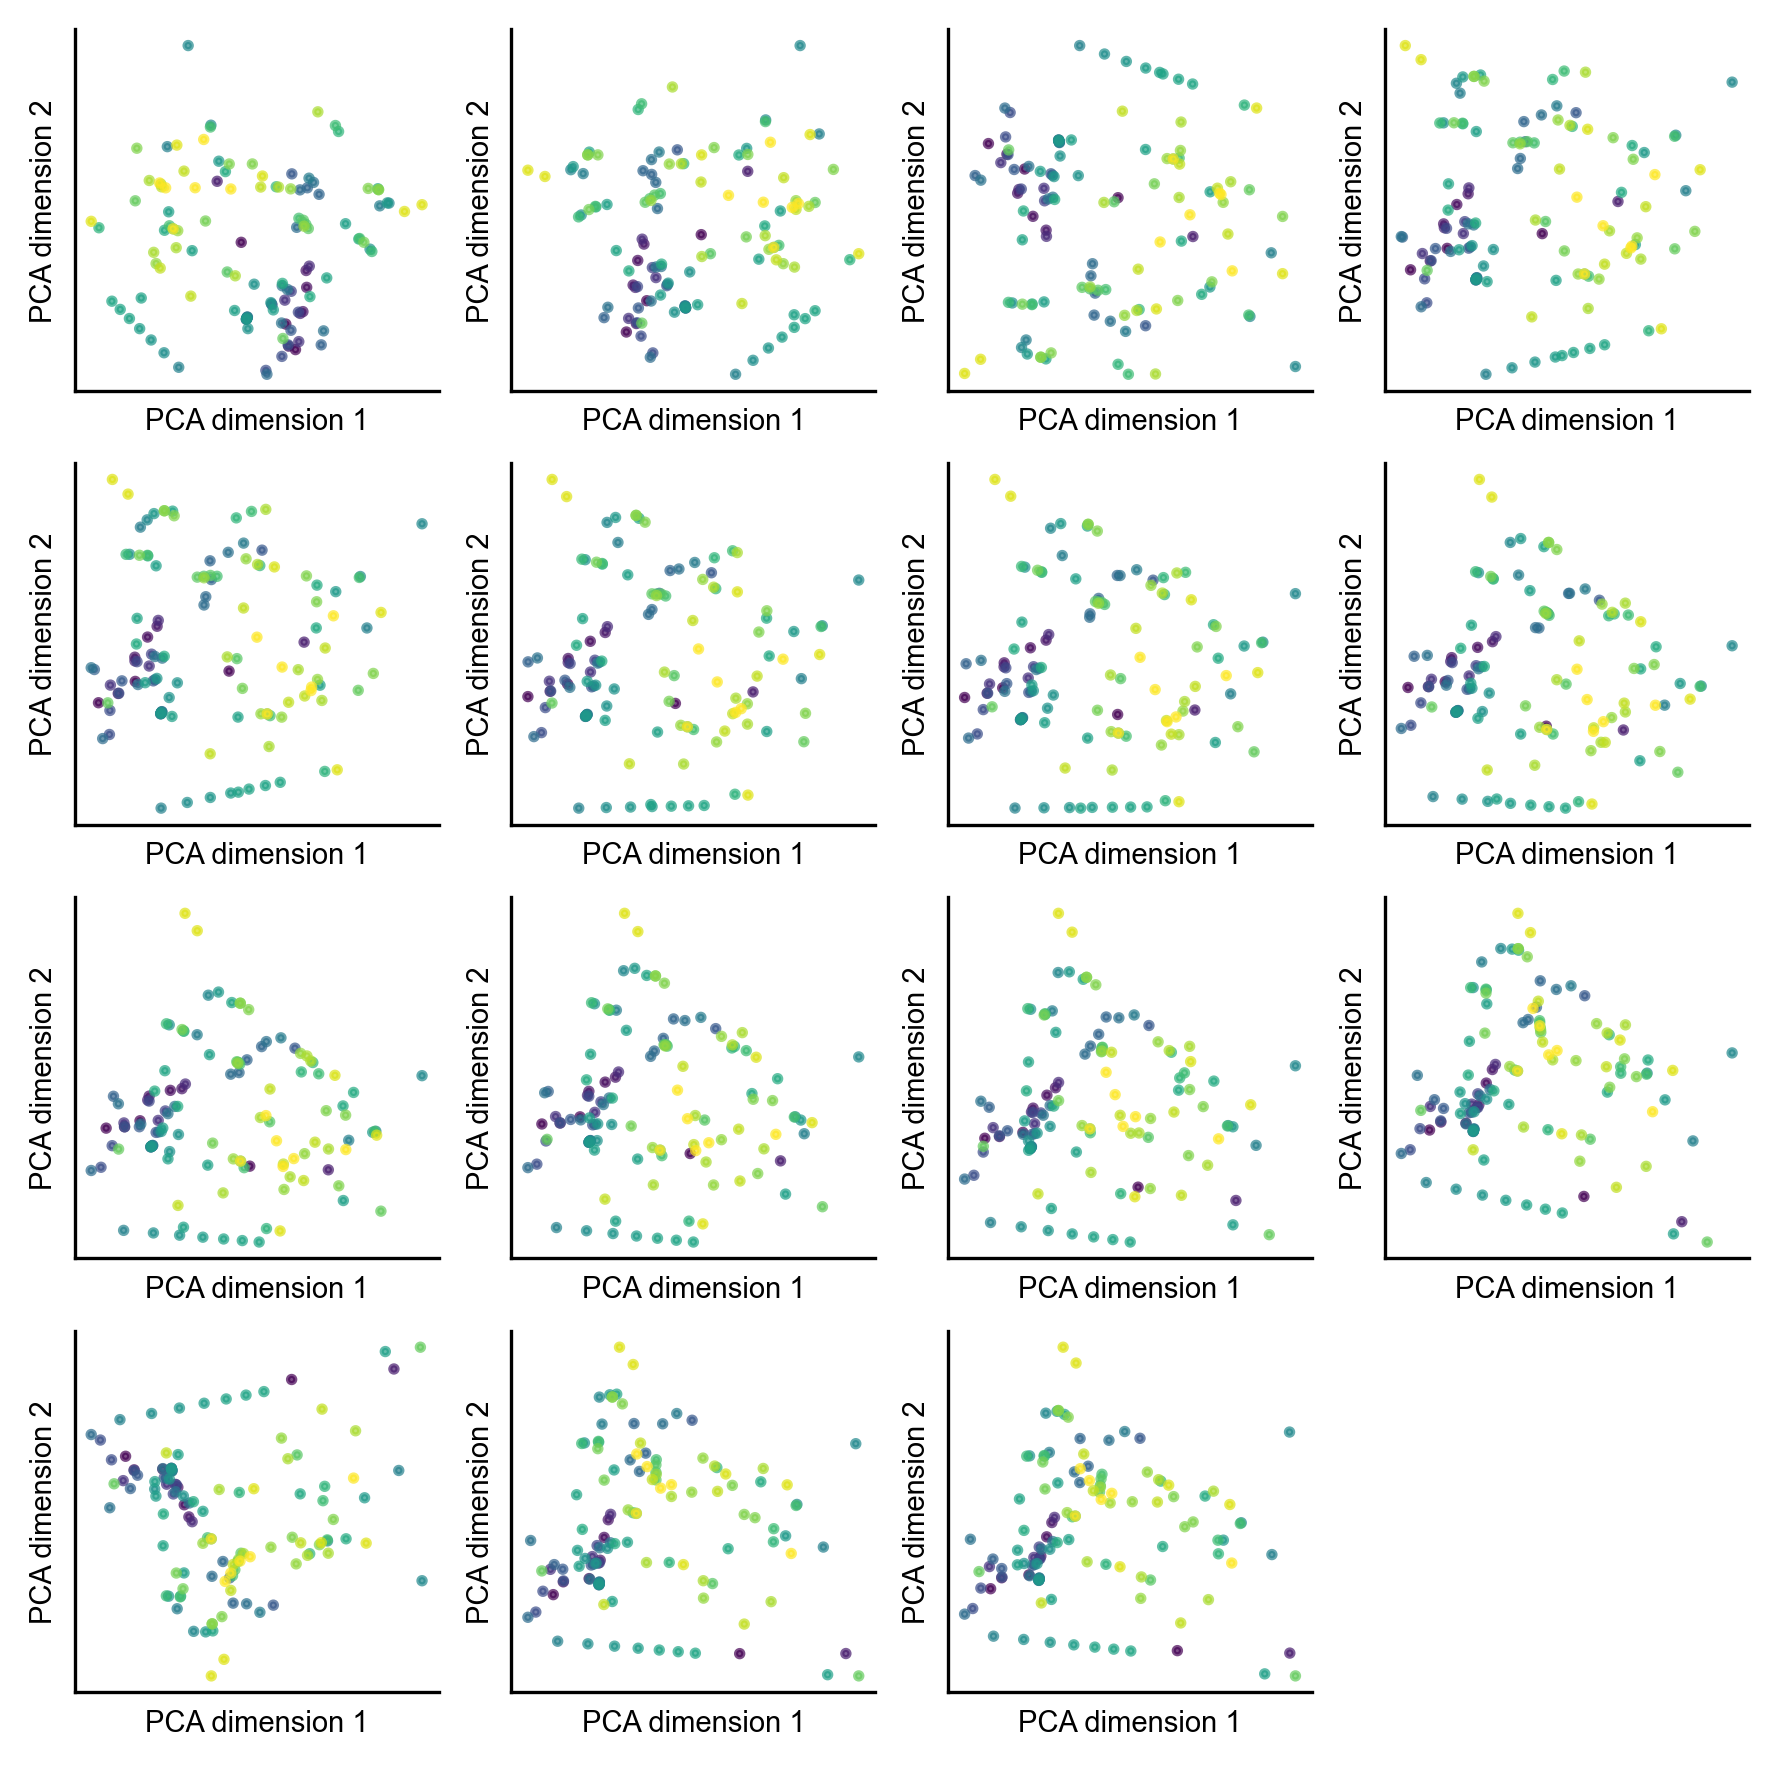

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap
# Arial 7pt
plt.rc('font', family='Arial', size=7)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

# -------------------------------
# 2. Prepare data and MLIP model
# -------------------------------
fig, axes = plt.subplots(4,4, figsize=(7.2,7.2))
axes = axes.flatten()
# Open a file to write outputs
output_file = f"output/output_pnas_plot.txt"
with open(output_file, "w") as out:
    orbff = pretrained.orb_v2(device=device)
    orbff.model.eval()
    for layer in range(1,16):
        out.write(f"Layer: {layer}\n")
        for relax in ['X']:
            out.write(f"Relaxation: {relax}\n")
            X = []
            Y = {key: [] for key in property_cols}

            # Convert SMILES to ASE atoms with 2D conformation while checking for errors
            for i, row in tqdm(enumerate(exp_parsed)):
            # for i, row in tqdm(data.iloc[:10].iterrows()):
                try:
                    feat = exp_features_concent(row['exp'], conformation=False, concentration_type=-1, model=orbff.model, layer=layer, device=device)
                    X.append(feat)
                    for key in property_cols:
                        Y[key].append(-np.log10(1 - row[key]/100))
                except Exception as e:
                    print(f"Error processing SMILES {row['exp']}: {e}")
            X = np.array(X)
            for prop in Y.keys():
                out.write(f"Property: {prop}\n")
                Y = np.array(Y[prop])

            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)
            
            axes[layer-1].scatter(X_pca[:,0], X_pca[:,1], c=Y, s=3, alpha=0.7)
            axes[layer-1].set_xticks([])
            axes[layer-1].set_yticks([])
            axes[layer-1].spines['right'].set_visible(False)
            axes[layer-1].spines['top'].set_visible(False)
            axes[layer-1].set_xlabel('PCA dimension 1')
            axes[layer-1].set_ylabel('PCA dimension 2')
    layer_remain = layer
    for layer in range(layer_remain,16):
        axes[layer].set_xticks([])
        axes[layer].set_yticks([])
        axes[layer].spines['right'].set_visible(False)
        axes[layer].spines['top'].set_visible(False)
        axes[layer].spines['left'].set_visible(False)
        axes[layer].spines['bottom'].set_visible(False)

/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:01, 108.10it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
54it [00:00, 80.54it/s][23:34:09] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:09] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
74it [00:00, 86.39it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:01, 87.32it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
53it [00:00, 68.51it/s][23:34:11] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:11] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
70it [00:00, 75.24it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:01, 72.92it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
52it [00:00, 56.80it/s][23:34:13] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:13] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
68it [00:01, 64.60it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 61.52it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
56it [00:01, 51.74it/s][23:34:15] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:15] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:01, 55.49it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 53.86it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
56it [00:01, 45.99it/s][23:34:18] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:18] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
68it [00:01, 50.09it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 47.58it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
56it [00:01, 40.69it/s][23:34:21] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:21] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
62it [00:01, 44.13it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 42.54it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
53it [00:01, 35.80it/s][23:34:24] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:24] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:01, 40.27it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 37.91it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
54it [00:01, 32.00it/s][23:34:28] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:28] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
64it [00:01, 37.60it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 34.90it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
53it [00:01, 30.02it/s][23:34:32] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:32] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
61it [00:01, 33.86it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:03, 32.49it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
55it [00:01, 28.90it/s][23:34:36] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:36] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:02, 32.90it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:04, 30.68it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
54it [00:02, 25.98it/s][23:34:40] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:40] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
62it [00:02, 31.10it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:04, 28.57it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
54it [00:02, 24.20it/s][23:34:45] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:45] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
62it [00:02, 29.10it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:04, 26.48it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
55it [00:02, 23.50it/s][23:34:50] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:50] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
63it [00:02, 26.93it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:05, 24.66it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
54it [00:02, 21.12it/s][23:34:55] SMILES Parse Error: syntax error while parsing: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
[23:34:55] SMILES Parse Error: Failed parsing SMILES 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' for input: 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F'
61it [00:02, 24.56it/s]

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:05, 23.51it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


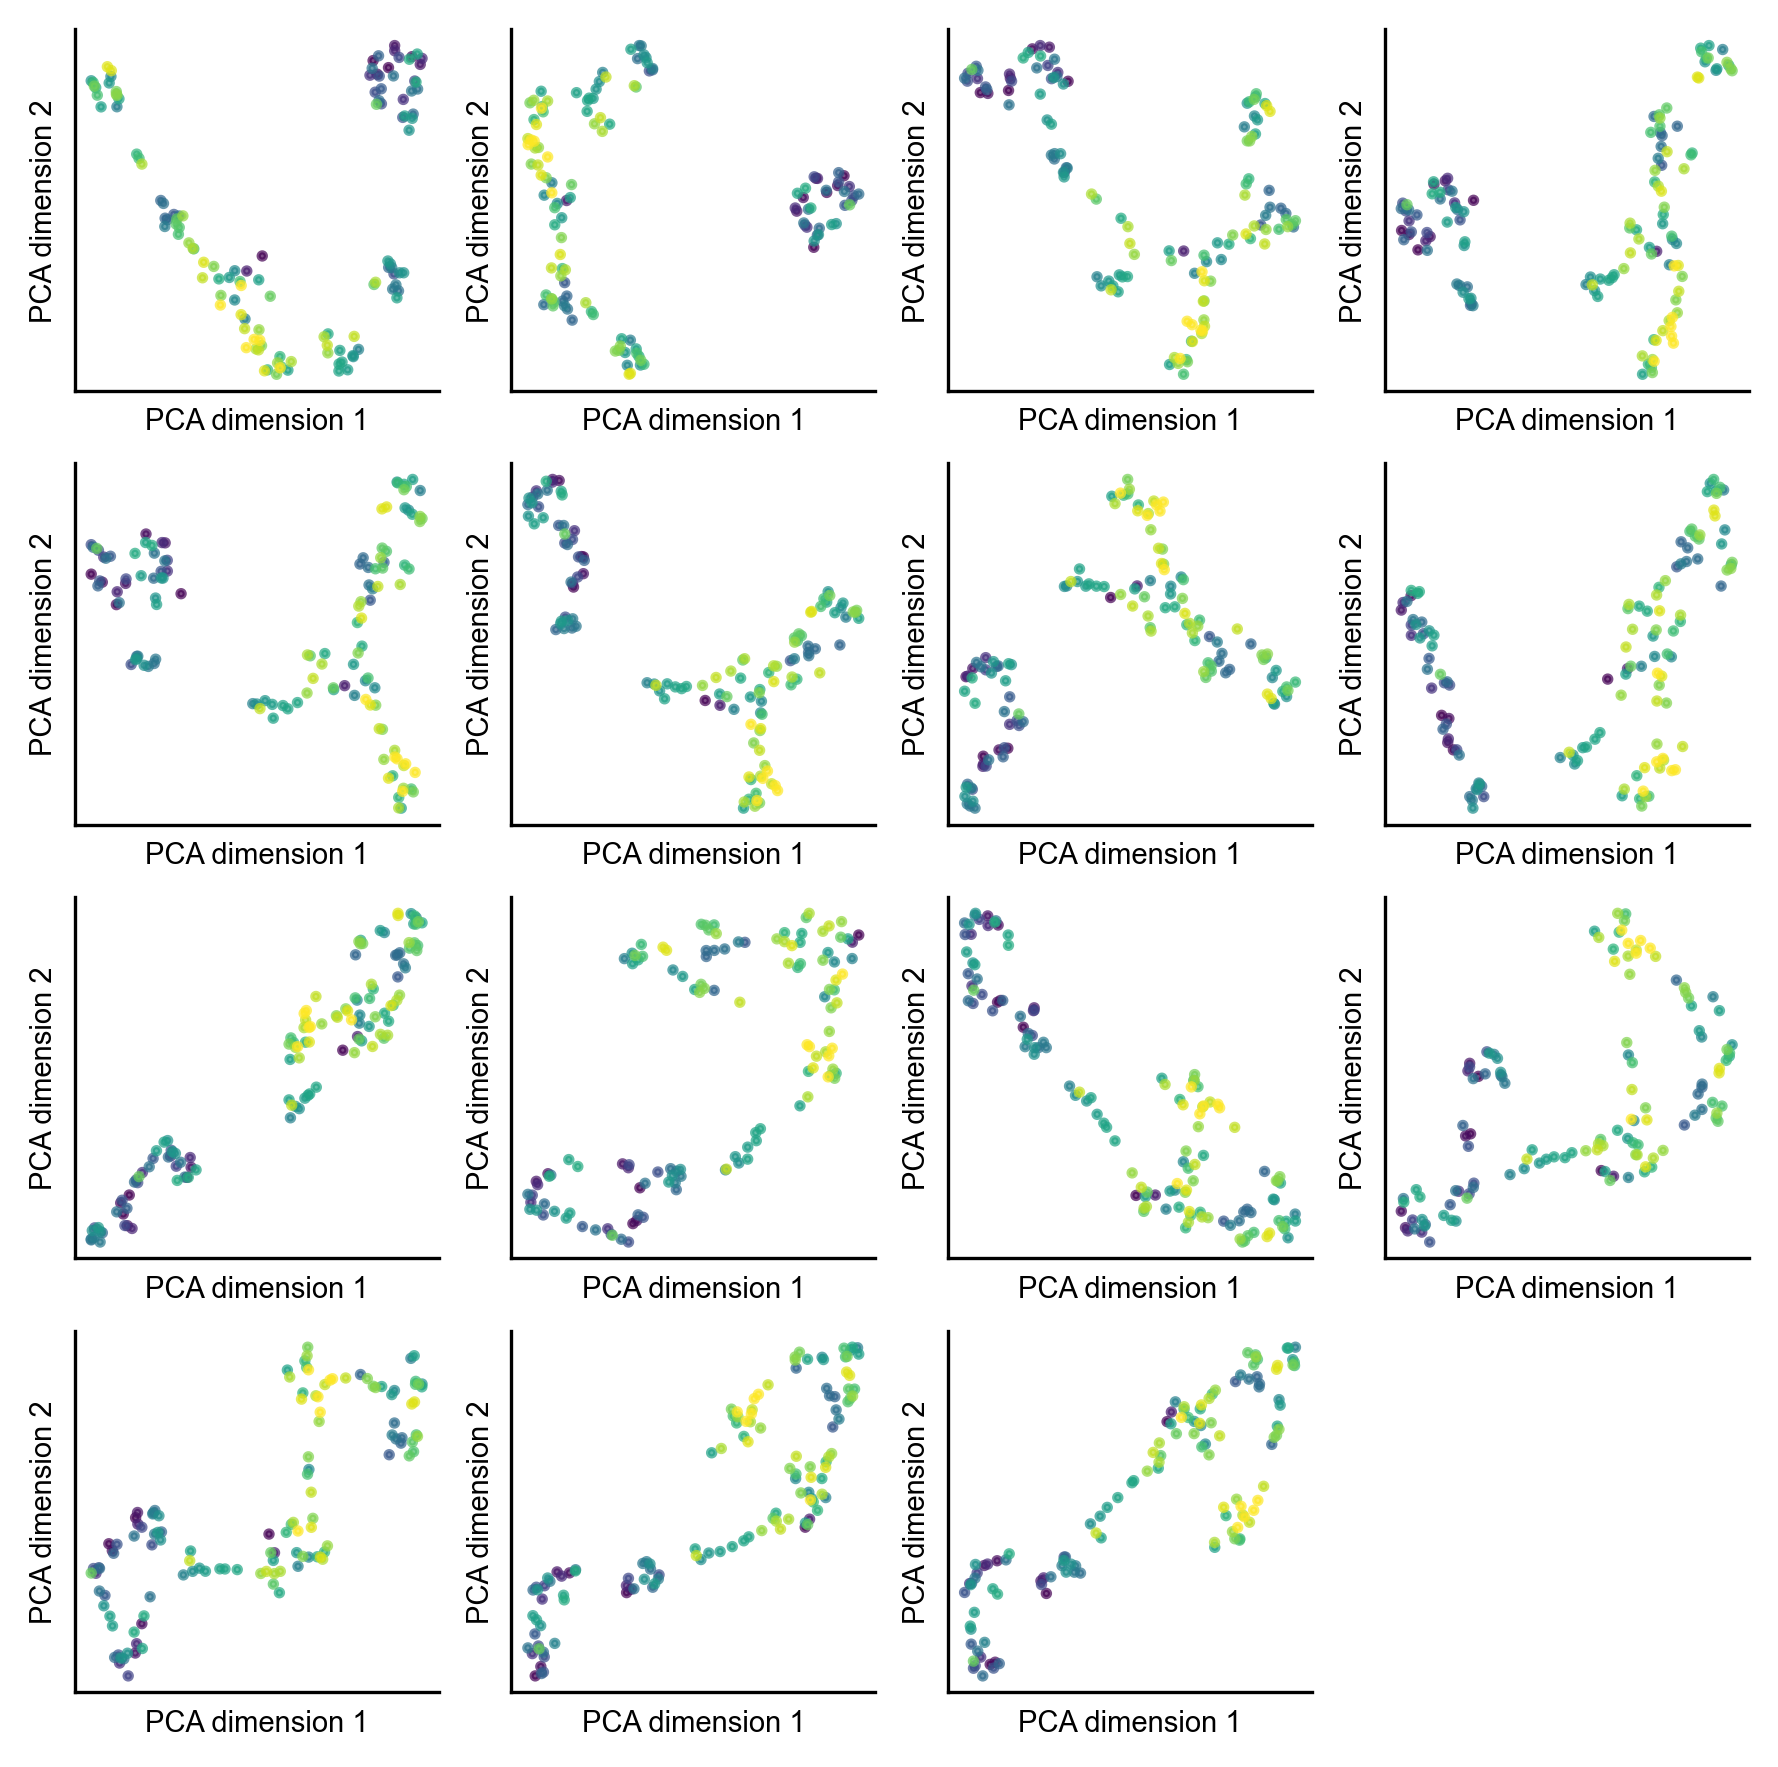

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap
# Arial 7pt
plt.rc('font', family='Arial', size=7)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

# -------------------------------
# 2. Prepare data and MLIP model
# -------------------------------
fig, axes = plt.subplots(4,4, figsize=(7.2,7.2))
axes = axes.flatten()
# Open a file to write outputs
output_file = f"output/output_pnas_plot.txt"
with open(output_file, "w") as out:
    orbff = pretrained.orb_v2(device=device)
    orbff.model.eval()
    for layer in range(1,16):
        out.write(f"Layer: {layer}\n")
        for relax in ['X']:
            out.write(f"Relaxation: {relax}\n")
            X = []
            Y = {key: [] for key in property_cols}

            # Convert SMILES to ASE atoms with 2D conformation while checking for errors
            for i, row in tqdm(enumerate(exp_parsed)):
            # for i, row in tqdm(data.iloc[:10].iterrows()):
                try:
                    feat = exp_features_concent(row['exp'], conformation=False, concentration_type=-1, model=orbff.model, layer=layer, device=device)
                    X.append(feat)
                    for key in property_cols:
                        Y[key].append(-np.log10(1 - row[key]/100))
                except Exception as e:
                    print(f"Error processing SMILES {row['exp']}: {e}")
            X = np.array(X)
            for prop in Y.keys():
                out.write(f"Property: {prop}\n")
                Y = np.array(Y[prop])

            umap_map = umap.UMAP(n_components=2, random_state=42)
            X_umap = umap_map.fit_transform(X)
            
            axes[layer-1].scatter(X_umap[:,0], X_umap[:,1], c=Y, s=3, alpha=0.7)
            axes[layer-1].set_xticks([])
            axes[layer-1].set_yticks([])
            axes[layer-1].spines['right'].set_visible(False)
            axes[layer-1].spines['top'].set_visible(False)
            axes[layer-1].set_xlabel('PCA dimension 1')
            axes[layer-1].set_ylabel('PCA dimension 2')
    layer_remain = layer
    for layer in range(layer_remain,16):
        axes[layer].set_xticks([])
        axes[layer].set_yticks([])
        axes[layer].spines['right'].set_visible(False)
        axes[layer].spines['top'].set_visible(False)
        axes[layer].spines['left'].set_visible(False)
        axes[layer].spines['bottom'].set_visible(False)

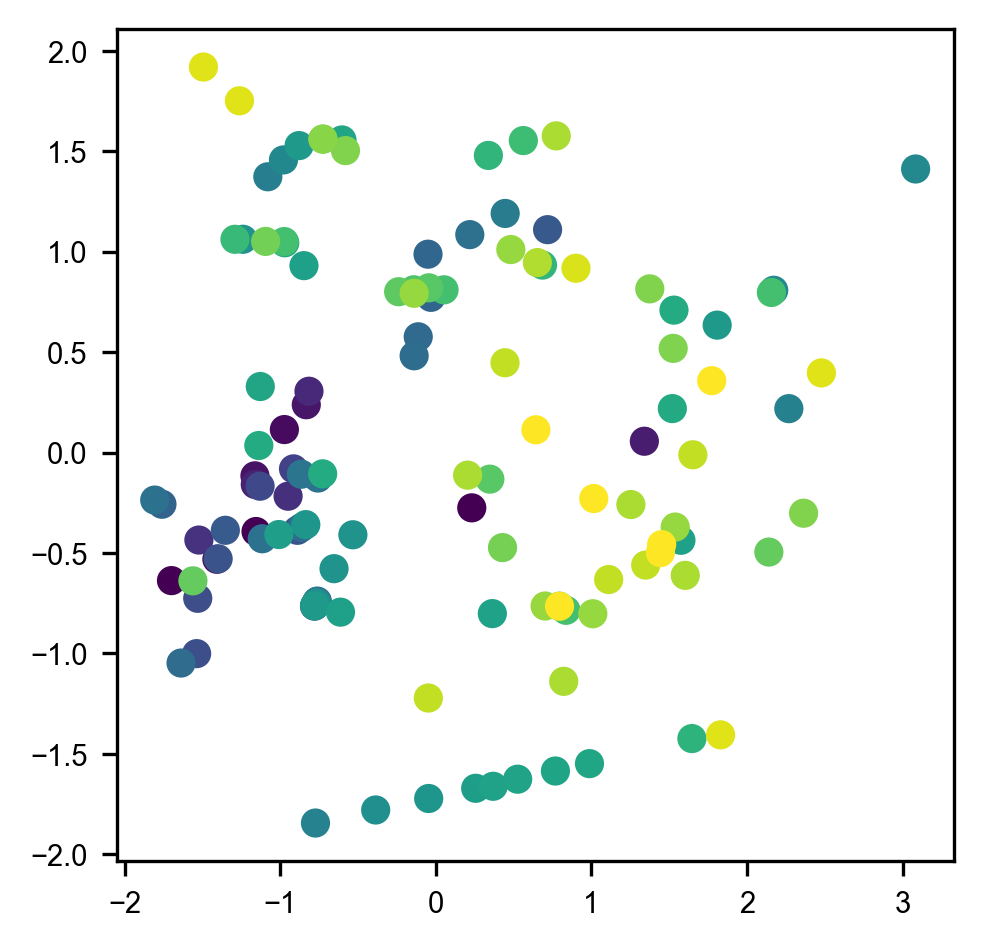

In [11]:
# PCA visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=7)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(3.6,3.6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y)


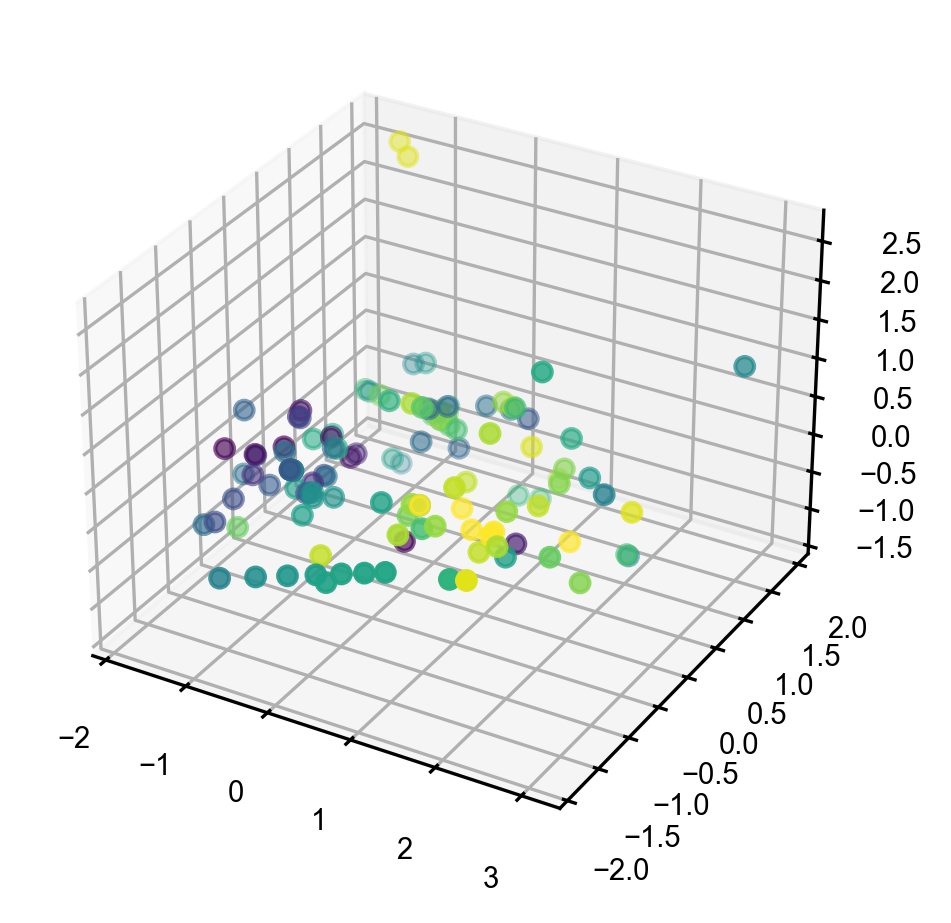

In [12]:

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
fig = plt.figure(figsize=(3.6,3.6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=Y)

In [14]:
!pip install umap-learn

/bin/bash: /home/lucky/anaconda3/envs/cd_ionic/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)


In [26]:
import umap
umap_map = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_map.fit_transform(X)

/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0, 0.5, 'UMAP dimension 2')

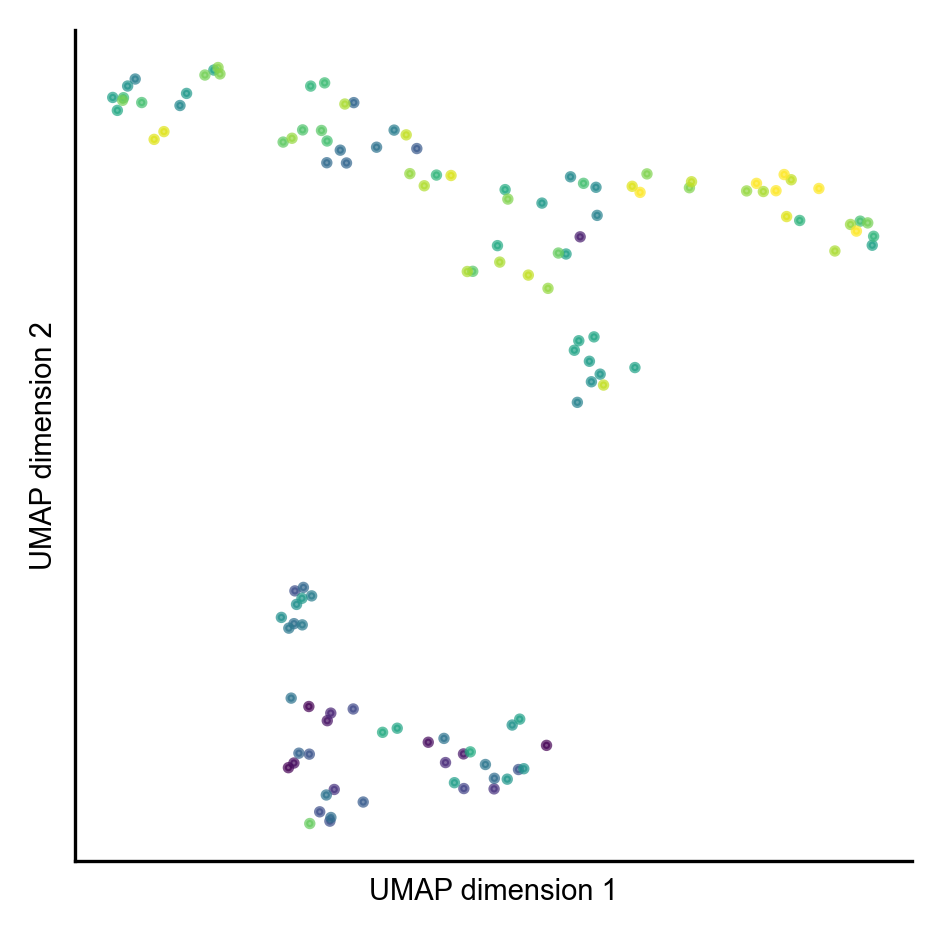

In [27]:

plt.figure(figsize=(3.6,3.6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=Y, s=3, alpha=.7)

plt.xticks([])
plt.yticks([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

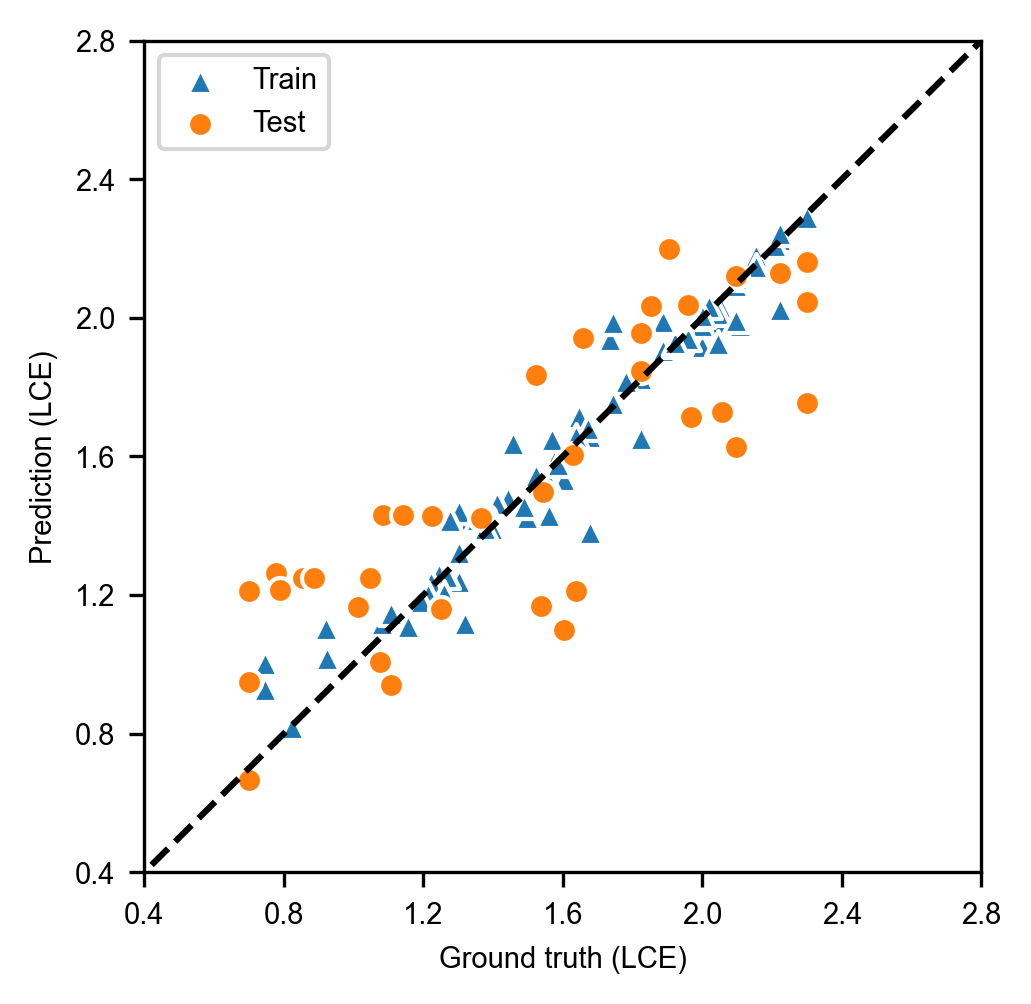

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Arial 7pt
plt.rc('font', family='Arial', size=7)
mpl.rcParams['figure.dpi'] = 300  # 원하는 DPI 값
plt.figure(figsize=(3.6, 3.6))
# triangle for train with white edge
plt.scatter(train_Y, mlp.predict(train_X), label='Train', marker='^', edgecolor='white')
plt.scatter(test_Y, preds, label='Test', marker='o', edgecolor='white')
plt.plot([0, 2.8], [0, 2.8], 'k--')
plt.xlabel('Ground truth (LCE)')
plt.ylabel('Prediction (LCE)')
plt.xlim(0.4,2.8)
plt.ylim(0.4,2.8)
plt.xticks([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8])
plt.yticks([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8])
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel

# -------------------------------
# 2. Prepare data and MLIP model
# -------------------------------
# Open a file to write outputs
output_file = "output/output_gpr_ucb.txt"
with open(output_file, "w") as out:
    orbff = pretrained.orb_v2(device=device)
    orbff.model.eval()
    for layer in range(5, 6):
        out.write(f"Layer: {layer}\n")
        for relax in ['X']:
            out.write(f"Relaxation: {relax}\n")
            X = []
            Y = {key: [] for key in property_cols}

            # Convert SMILES to ASE atoms with 2D conformation while checking for errors
            for i, row in tqdm(enumerate(exp_parsed)):
                try:
                    feat = exp_features_concent(row['exp'], conformation=False, concentration_type=-1,
                                          model=orbff.model, layer=layer, device=device)
                    X.append(feat)
                    for key in property_cols:
                        # Transform the property value as in your original code
                        Y[key].append(-np.log10(1 - row[key] / 100))
                except Exception as e:
                    print(f"Error processing SMILES {row['exp']}: {e}")
            X = np.array(X)
            
            # For each property, run sequential optimization using GPR + UCB
            for prop in Y.keys():
                out.write(f"Property: {prop}\n")
                Y_prop = np.array(Y[prop])
                
                # Define the sequential optimization parameters
                n_initial = 5     # number of initial points
                n_iter = 50       # number of sequential iterations
                kappa = 2.0       # exploration parameter for UCB (adjust as needed)

                # Create index arrays for the candidate pool (all indices)
                all_indices = np.arange(len(X))
                # Select initial observed indices randomly
                np.random.seed(0)
                observed_indices = np.random.choice(all_indices, size=n_initial, replace=False)
                candidate_indices = np.setdiff1d(all_indices, observed_indices)
                
                # Record the cumulative maximum values
                cumulative_max = []
                observed_Y = Y_prop[observed_indices]
                current_max = np.max(observed_Y)
                cumulative_max.append(current_max)
                
                # Sequential optimization loop
                for i in range(n_iter):
                    # Define and fit the GPR model on currently observed data
                    kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
                    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
                    gpr.fit(X[observed_indices], Y_prop[observed_indices])
                    
                    # Predict mean and standard deviation on candidate points
                    mu, sigma = gpr.predict(X[candidate_indices], return_std=True)
                    # Compute the UCB acquisition value
                    ucb = mu + kappa * sigma
                    
                    # Select the candidate with the highest UCB
                    best_idx = np.argmax(ucb)
                    best_candidate = candidate_indices[best_idx]
                    
                    # Add the selected candidate to the observed set
                    observed_indices = np.append(observed_indices, best_candidate)
                    observed_Y = np.append(observed_Y, Y_prop[best_candidate])
                    
                    # Remove the selected candidate from the candidate pool
                    candidate_indices = np.delete(candidate_indices, best_idx)
                    
                    # Update and record the cumulative maximum
                    current_max = np.max(observed_Y)
                    cumulative_max.append(current_max)
                    out.write(f"Iteration {i+1}: selected index {best_candidate}, current max: {current_max}\n")
                    print(f"Iteration {i+1}: selected index {best_candidate}, current max: {current_max}")
                
                    plt.figure(figsize=(3.6, 3.6))
                    plt.scatter(observed_Y, Y_prop[observed_indices], label='Observed', marker='^', edgecolor='white')
                    plt.scatter(Y_prop[best_candidate], Y_prop[best_candidate], label='Best Candidate', marker='o', edgecolor='red')
                    plt.plot([0, 2.8], [0, 2.8], 'k--')
                    plt.xlim(0.4, 2.8)
                    plt.ylim(0.4, 2.8)
                    plt.xticks([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8])
                    plt.yticks([0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8])
                    plt.xlabel('Ground truth (LCE)')
                    plt.ylabel('Prediction (LCE)')
                    plt.grid(True)
                    # Save the plot (or you can use plt.show() to display it)
                    plt.savefig(f"output/cumulative_max_{prop}_{i}.png")
                    plt.close()

                # Plot cumulative maximum values over iterations
                plt.figure(figsize=(8, 6))
                plt.plot(cumulative_max, marker='o')
                plt.plot(observed_Y[4:], marker='^', label='Observed')
                plt.xlabel('Iteration')
                plt.ylabel('Cumulative Max Value')
                plt.title(f'Sequential Optimization for {prop} using GPR and UCB')
                plt.grid(True)
                # Save the plot (or you can use plt.show() to display it)
                plt.savefig(f"output/cumulative_max_{prop}.png")
                plt.close()


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 52.62it/s]
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 1: selected index 52, current max: 1.6289321377282644
Iteration 2: selected index 98, current max: 2.045757490560675


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 3: selected index 100, current max: 2.0506099933550863
Iteration 4: selected index 106, current max: 2.0969100130080562


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 5: selected index 88, current max: 2.0969100130080562
Iteration 6: selected index 69, current max: 2.0969100130080562


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 7: selected index 70, current max: 2.0969100130080562
Iteration 8: selected index 114, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 9: selected index 105, current max: 2.221848749616364
Iteration 10: selected index 40, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 11: selected index 44, current max: 2.221848749616364
Iteration 12: selected index 79, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 13: selected index 94, current max: 2.221848749616364
Iteration 14: selected index 116, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 15: selected index 115, current max: 2.221848749616364
Iteration 16: selected index 76, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 17: selected index 110, current max: 2.221848749616364
Iteration 18: selected index 117, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 19: selected index 39, current max: 2.221848749616364
Iteration 20: selected index 7, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 

Iteration 21: selected index 92, current max: 2.221848749616364
Iteration 22: selected index 109, current max: 2.221848749616364


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 23: selected index 120, current max: 2.301029995663981
Iteration 24: selected index 112, current max: 2.301029995663981


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 25: selected index 102, current max: 2.301029995663981
Iteration 26: selected index 73, current max: 2.301029995663981
Iteration 27: selected index 123, current max: 2.301029995663981
Iteration 28: selected index 122, current max: 2.301029995663981
Iteration 29: selected index 111, current max: 2.301029995663981
Iteration 30: selected index 62, current max: 2.301029995663981
Iteration 31: selected index 85, current max: 2.301029995663981
Iteration 32: selected index 23, current max: 2.301029995663981
Iteration 33: selected index 121, current max: 2.301029995663981
Iteration 34: selected index 25, current max: 2.301029995663981
Iteration 35: selected index 93, current max: 2.301029995663981
Iteration 36: selected index 87, current max: 2.301029995663981
Iteration 37: selected index 113, current max: 2.301029995663981
Iteration 38: selected index 107, current max: 2.301029995663981
Iteration 39: selected index 104, current max: 2.301029995663981
Iteration 40: selected index 19,

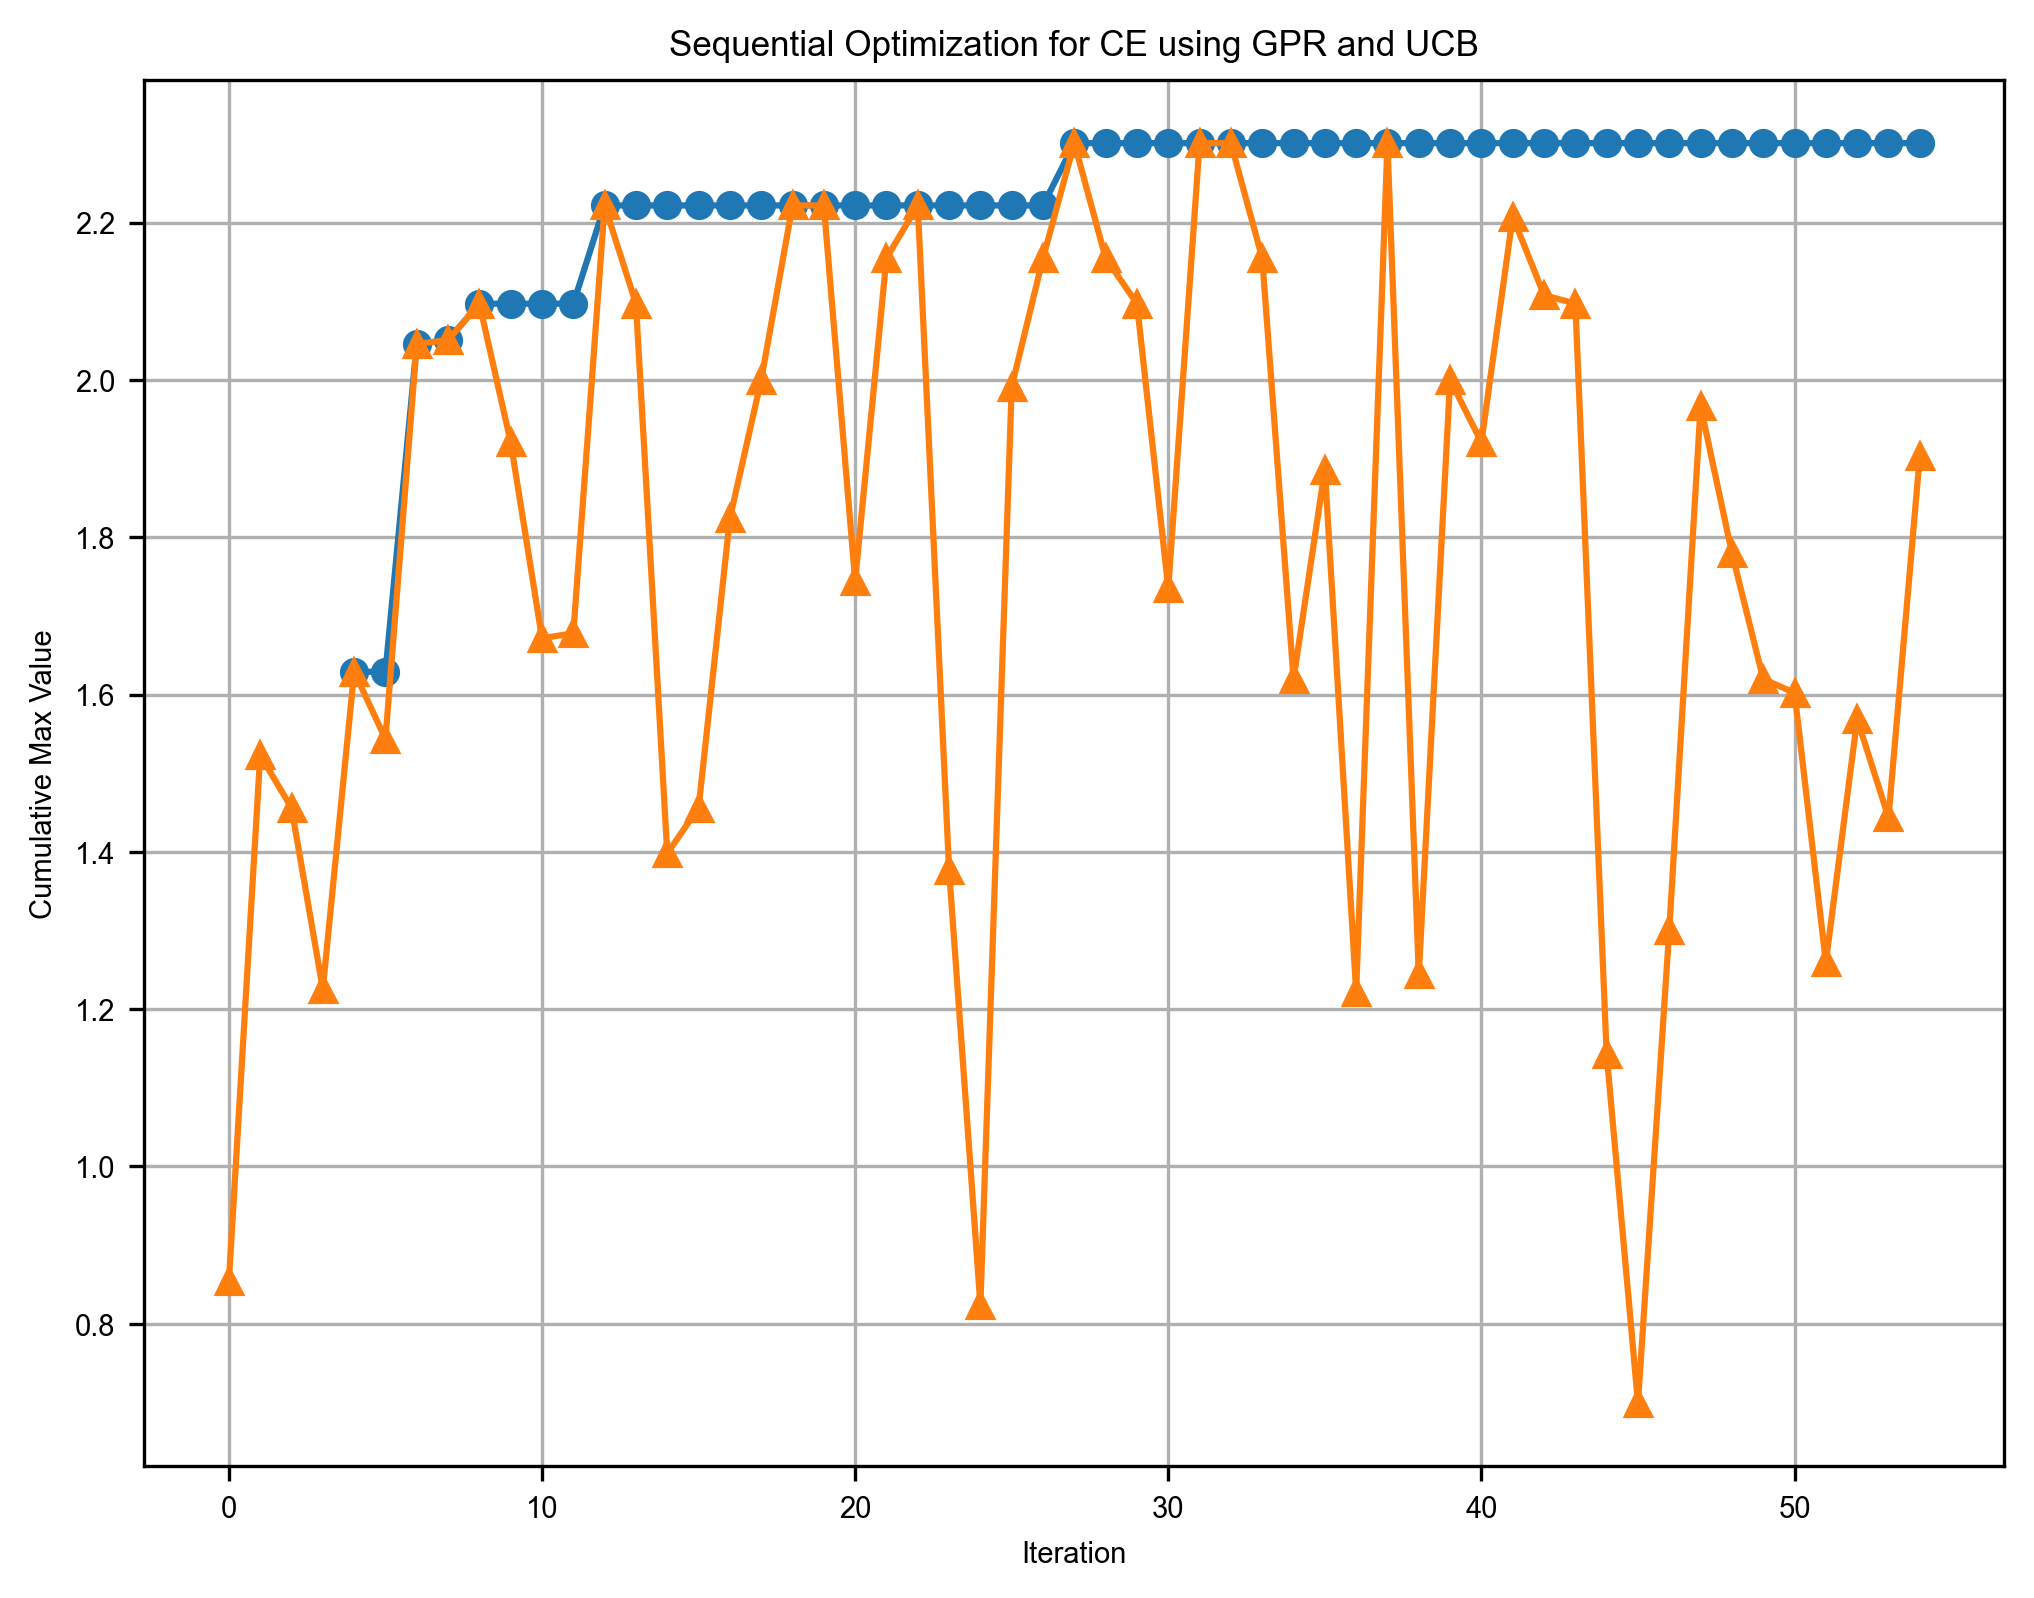

In [ ]:

# Plot cumulative maximum values over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(4, len(observed_Y)), np.array(cumulative_max), marker='o')
plt.plot(observed_Y, marker='^', label='Observed')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Max Value')
plt.title(f'Sequential Optimization for {prop} using GPR and UCB')
plt.grid(True)
# # Save the plot (or you can use plt.show() to display it)
# plt.savefig(f"output/cumulative_max_{prop}.png")
# plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------------
# 2. Prepare data and MLIP model
# -------------------------------
# Open a file to write outputs
output_file = "output/output_random_cumulative_max.txt"
with open(output_file, "w") as out:
    orbff = pretrained.orb_v2(device=device)
    orbff.model.eval()
    for layer in range(5, 6):
        out.write(f"Layer: {layer}\n")
        for relax in ['X']:
            out.write(f"Relaxation: {relax}\n")
            X = []
            Y = {key: [] for key in property_cols}

            # Convert SMILES to ASE atoms with 2D conformation while checking for errors
            for i, row in tqdm(enumerate(exp_parsed)):
                try:
                    feat = exp_features_concent(row['exp'], conformation=False, concentration_type=-1,
                                          model=orbff.model, layer=layer, device=device)
                    X.append(feat)
                    for key in property_cols:
                        # Transform the property value as in your original code
                        Y[key].append(-np.log10(1 - row[key] / 100))
                except Exception as e:
                    print(f"Error processing SMILES {row['exp']}: {e}")
            X = np.array(X)
            
            # For each property, perform random selection and plot cumulative maximum
            for prop in Y.keys():
                out.write(f"Property: {prop}\n")
                Y_prop = np.array(Y[prop])
                
                # Define parameters for the sequential process
                n_initial = 5     # number of initial random points
                n_iter = 50       # number of sequential iterations
                
                # Create index arrays for the candidate pool (all indices)
                all_indices = np.arange(len(X))
                # Select initial observed indices randomly
                np.random.seed(0)
                observed_indices = np.random.choice(all_indices, size=n_initial, replace=False)
                candidate_indices = np.setdiff1d(all_indices, observed_indices)
                
                # Record the cumulative maximum values
                cumulative_max = []
                observed_Y = Y_prop[observed_indices]
                current_max = np.max(observed_Y)
                cumulative_max.append(current_max)
                
                # Sequential random selection loop
                for i in range(n_iter):
                    # Randomly select a candidate from the pool
                    rand_idx = np.random.choice(len(candidate_indices), size=1)[0]
                    selected_candidate = candidate_indices[rand_idx]
                    
                    # Add the selected candidate to the observed set and remove from candidate pool
                    observed_indices = np.append(observed_indices, selected_candidate)
                    observed_Y = np.append(observed_Y, Y_prop[selected_candidate])
                    candidate_indices = np.delete(candidate_indices, rand_idx)
                    
                    # Update and record the cumulative maximum
                    current_max = np.max(observed_Y)
                    cumulative_max.append(current_max)
                    out.write(f"Iteration {i+1}: selected index {selected_candidate}, current max: {current_max}\n")
                    print(f"Iteration {i+1}: selected index {selected_candidate}, current max: {current_max}")
                
                # Plot cumulative maximum values over iterations
                plt.figure(figsize=(8, 6))
                plt.plot(cumulative_max, marker='o')
                plt.xlabel('Iteration')
                plt.ylabel('Cumulative Max Value')
                plt.title(f'Random Selection Cumulative Max for {prop}')
                plt.grid(True)
                # Save the plot (or use plt.show() to display it)
                plt.savefig(f"output/cumulative_max_random_{prop}.png")
                plt.close()


/home/lucky/anaconda3/envs/ionic2/lib/python3.9/site-packages/orb_models/forcefield/pretrained.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(l

Error processing SMILES {'C1COCO1': ['DOL', 40.15279481686619, 37.87999511025112, 0.5420266852531244], 'COCCOC': ['DME', 32.879835755697975, 37.87999511025112, 0.36483695163997665], '[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': ['LiTFSI', 21.749784072423545, 16.35322110708537, 0.07575999022050224], 'CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F': ['TMS-FNFSI', 4.98854813920988, nan, 0.017376372886396783]}: Could not parse SMILES string: CSi(C)(C)([N+]).C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


125it [00:02, 49.84it/s]


Iteration 1: selected index 25, current max: 1.6289321377282644
Iteration 2: selected index 65, current max: 1.6382721639824067
Iteration 3: selected index 2, current max: 1.6382721639824067
Iteration 4: selected index 106, current max: 2.0969100130080562
Iteration 5: selected index 70, current max: 2.0969100130080562
Iteration 6: selected index 39, current max: 2.0969100130080562
Iteration 7: selected index 104, current max: 2.0969100130080562
Iteration 8: selected index 77, current max: 2.0969100130080562
Iteration 9: selected index 93, current max: 2.0969100130080562
Iteration 10: selected index 53, current max: 2.0969100130080562
Iteration 11: selected index 114, current max: 2.221848749616364
Iteration 12: selected index 22, current max: 2.221848749616364
Iteration 13: selected index 95, current max: 2.221848749616364
Iteration 14: selected index 59, current max: 2.221848749616364
Iteration 15: selected index 32, current max: 2.221848749616364
Iteration 16: selected index 16, curr

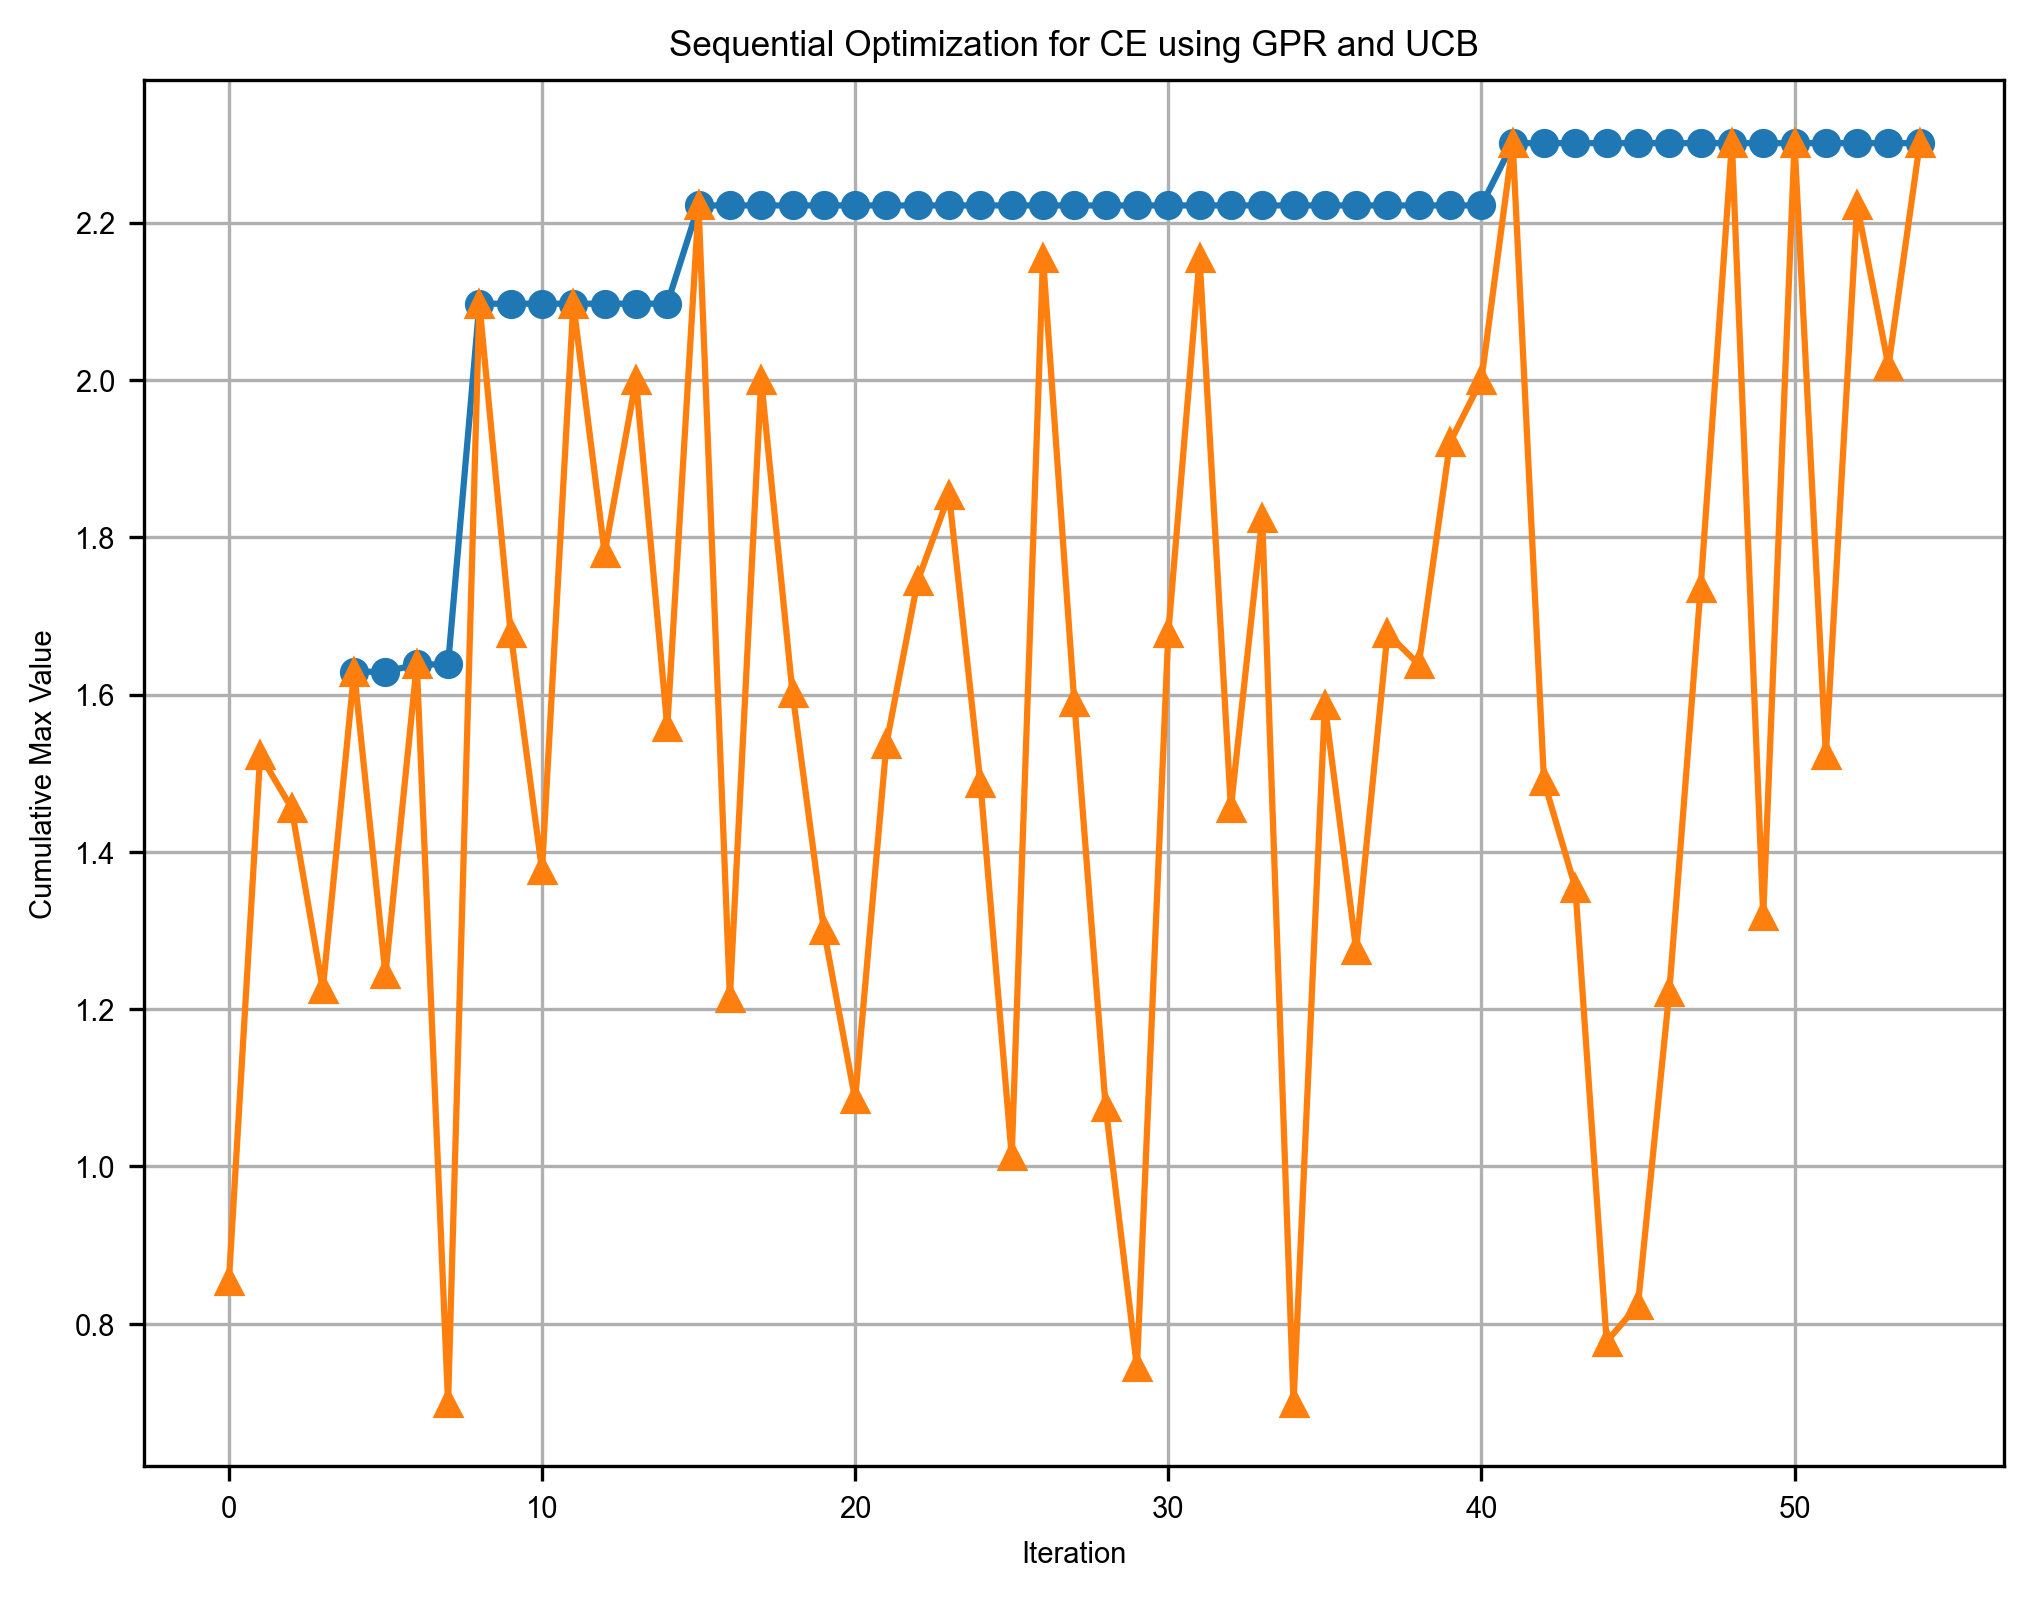

In [31]:

# Plot cumulative maximum values over iterations
plt.figure(figsize=(8, 6))
plt.plot(range(4, len(observed_Y)), np.array(cumulative_max), marker='o')
plt.plot(observed_Y, marker='^', label='Observed')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Max Value')
plt.title(f'Sequential Optimization for {prop} using GPR and UCB')
plt.grid(True)
# # Save the plot (or you can use plt.show() to display it)

In [10]:
import re

def parse_electrolyte(desc):
    # Remove concentration part (e.g., "1 M" or "1M")
    desc_clean = re.sub(r"^\s*\d+\s*M\s*", "", desc, flags=re.IGNORECASE)
    tokens = desc_clean.split()
    salt = None
    solvents = []
    if tokens:
        # Check if first token contains a hyphen (e.g., "LiClO4-PC")
        if '-' in tokens[0]:
            parts = tokens[0].split('-')
            salt = parts[0]
            solvents.extend(parts[1:])
        else:
            salt = tokens[0]
        # Process remaining tokens
        for token in tokens[1:]:
            # Skip tokens that are plus signs or percentages
            if token == '+' or '%' in token:
                continue
            # Skip tokens that are likely ratio info in parentheses
            if token.startswith('(') or token.endswith(')'):
                continue
            # If token contains hyphen, split and add all parts as solvents
            if '-' in token:
                solvents.extend(token.split('-'))
            else:
                solvents.append(token)
    salt_str = f"[{salt}]" if salt else ""
    solvent_str = f"[{','.join(solvents)}]" if solvents else ""
    return salt_str, solvent_str

# Iterate over the rows to update Solvent and Salt columns if they are missing
for idx, row in pnas.iterrows():
    # Use the "Unnamed: 1" column as the description
    desc = row["Unnamed: 1"]
    # Check if the description is a string and starts with a concentration (e.g., "1 M" or "1M")
    if isinstance(desc, str) and re.search(r'^\s*\d+\s*M', desc, flags=re.IGNORECASE):
        # Only update if the current Solvent or Salt are NaN or not in bracket format (i.e., missing)
        current_solvent = row["Solvent"]
        current_salt = row["Salt"]
        if (pd.isna(current_solvent)) or (pd.isna(current_salt)):
            salt_val, solvent_val = parse_electrolyte(desc)
            pnas.at[idx, "Salt"] = salt_val
            pnas.at[idx, "Solvent"] = solvent_val

pnas



,Unnamed: 0,Unnamed: 1,Solvent,Salt,Solvent 1,Solvent 2,Solvent 3,Solvent 1.1,Solvent 2.1,Solvent 3.1,...,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32
0,NaN,Electrolyte,NaN,NaN,Volume %,Volume %,Volume %,mol/L,mol/L,mol/L,...,C,sC,aC,CE (%),LCE,Method,Current (mA/cm2),Capacity (mAh/cm2),Cycle,Reference
1,NaN,1 M LiClO4-PC + 5% FEC,"[PC,FEC]",[LiClO4],1,0.05,NaN,11.754565,0.6855,NaN,...,0.29623,0.29623,0,80,0.69897,Cycle,0.5,0.083,30,2
2,NaN,1 M LiPF6 EC-DMC (1:1 v) 2% VC,"[EC,DMC,VC]",[LiPF6],0.5,0.5,0.02,7.49472,5.939297,0.313786,...,0.263151,0.263151,0,80,0.69897,Cycle,0.6,0.44,50,34
3,NaN,1 M LiBF4 EC-DMC (1:1 v) 2% VC,"[EC,DMC,VC]",[LiBF4],0.5,0.5,0.02,7.49472,5.939297,0.313786,...,0.263348,0.263348,0,80,0.69897,Cycle,0.6,0.44,50,34
4,NaN,1M LiTFPFB PC,[PC],[LiTFPFB],1,NaN,NaN,11.754565,NaN,NaN,...,0.292831,0.275267,0.017563,80.6,0.712198,Cycle,0.5,1,50,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,NaN,1.7 M LiFSI MeTHF-TTE (1:1 vol),NaN,NaN,0.5,0.5,NaN,3.301204,4.957622,NaN,...,0.265142,0.265142,0,99.5,2.30103,Cycle,1,1,40,45
147,NaN,LiFSI-1DME-3TTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2375,0.2375,0,99.5,2.30103,Aurbach,0.5,1,10,64
148,NaN,LiFSI-1.2DME-3TFEO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.240672,0.240672,0,99.5,2.30103,Aurbach,0.5,1,10,44
149,NaN,1.2 M LiFSI F4DEE,NaN,NaN,1,NaN,NaN,NaN,6.52151,NaN,...,0.251677,0.251677,0,99.5,2.30103,Aurbach,0.5,1,10,62


In [14]:
def parse_electrolyte_v2(desc):
    """
    Parses an electrolyte description string.
    Steps:
    1. Remove the leading concentration part (e.g., "1 M", "1.5M") using a robust regex.
    2. Then, the first contiguous token (which may include hyphens) is assumed to be the salt.
    3. The remaining tokens (ignoring known symbols like '+' and percentages) are assumed to be solvents.
    """
    # Remove leading concentration, which can be a float and optional space before M (or m)
    desc_clean = re.sub(r"^\s*\d*\.?\d+\s*[Mm]\s*", "", desc)
    
    # Remove any extra spaces around the '+' sign
    desc_clean = desc_clean.replace('+', ' + ')
    
    # Tokenize by whitespace
    tokens = desc_clean.split()
    
    salt = None
    solvents = []
    
    if not tokens:
        return "", ""
    
    # Assume salt is the first token; however, if it contains a hyphen, we check:
    # if the salt token is like "LiClO4-PC", then split on '-' to get salt and initial solvent.
    first_token = tokens[0]
    if '-' in first_token:
        parts = first_token.split('-')
        salt = parts[0]
        # If there are parts after the first, treat them as solvents
        solvents.extend(parts[1:])
    else:
        salt = first_token
    
    # Process remaining tokens
    for token in tokens[1:]:
        # Skip tokens that are '+' or contain '%' or are just symbols
        if token == '+' or '%' in token:
            continue
        # Skip tokens that are ratios or in parentheses
        if token.startswith('(') and token.endswith(')'):
            continue
        # Also skip tokens that are purely ratio information like "1:1" or "3:7"
        if re.match(r"^\d+:\d+$", token):
            continue
        # Remove trailing characters like 'v', 'wt', etc. if needed; but sometimes they are solvents like "DEC" or "DMC".
        # Here, if token.lower() in ["v", "wt", "vol", "mol", "by", "molar"]:
        #    continue
        # Instead, we can just add the token.
        # If token contains a hyphen, split it.
        if '-' in token:
            solvents.extend(token.split('-'))
        else:
            solvents.append(token)
    
    # Clean up: Remove any tokens that are empty or just punctuation.
    solvents = [s for s in solvents if s.strip() and s not in ['+', '&']]
    
    salt_str = f"[{salt}]" if salt else ""
    solvent_str = f"[{','.join(solvents)}]" if solvents else ""
    return salt_str, solvent_str

test_strings = """#NAME?	Solvent	Salt
Electrolyte		
1 M LiClO4-PC + 5% FEC	[PC,FEC]	[LiClO4]
1 M LiPF6 EC-DMC (1:1 v) 2% VC	[EC,DMC,VC]	[LiPF6]
1 M LiBF4 EC-DMC (1:1 v) 2% VC		
1M LiTFPFB PC		
1 M LiPF6 EC-EMC (3:7 wt) 2% wt VC		
1 M LiTFSI EC-DMC (1:1 v) 2% VC		
1M LiPF6 EC-DMC (3:7 v/v)		
1M LiPF6 EC-DEC (1:2 w/w)		
1.5 M LiAsF6-PC		
1 M LiBETI EC-DMC (1:1 v) 2% VC		
1 M LiPF6 EC-DMC (1:2 vol)		
1 M LiPF6 EC-DEC (3:7 wt)		
1 M LiPF6-EC/DEC (1:1 vol.)		
0.6M LiTFSI 0.4M LiBOB EC-EMC (5:5 wt)		
1M LiPF6 EC-DEC (1:1 w/w)		
1 M LiPF6 EC-DMC (1:2 vol) 2% TTFEB		
0.6M LiTFSI 0.4M LiBOB EC-EMC (7:3 wt)		
0.6M LiTFSI 0.4M LiBOB EC-EMC (9:1 wt)		
1 M LiPF6 FEC-DMC (1:1 v)		
1 M LiPF6 FEC-EC-DEC (2:9:9 vol)		
1 M LiTFSI EC-DMC (1:1 v) 5wt% FEC		
3.57 M LiTFSI DME		
1M LiFSI EC/DEC (v 1:1)		
0.1M LiDFP 0.4M LiTFSI EC-DMC (3:7 v/v)		
0.84 M LiTFSI 2.7M LiDFP DME		
1 M LiFSI in tetraglyme		
1 M LiPF6 FEC-DMC (1:1 v) 0.25wt% 12-Crown-4		
0.11 M LiTFSI 3.9 M LiDFP DME		
1 M LiPF6 FEC-EC-DEC (2:9:9 vol) 0.05 M RbNO3 0.05M 18-crown-6		
0.1M LiDFP 0.4M LiFSI EC-DMC (3:7 v/v)		
2M LiTFSI 2M LiDFOB DME		
1 M LiPF6 FEC-DMC (1:1 v) 2wt% 12-Crown-4		
2.2 M LiTFSI 0.8 M LiDFP DME		
1 M LiPF6-EC/DEC (1:1 vol.) + 5 vol% FEC		
0.02M Li2S5 0.15M LiNO3 1M LiTFSI DOL-DME (1:1 vol)		
1 M LiFSI in DEG-FTriEG		
1 M LiDFOB EC-DEC (3:7 wt)		
1 M LiPF6 FEC-EMC-DMC (34.6:57.2:8.2 wt) 		
1 M LiPF6 in EC/DEC + 0.15M LiDFP		
1 M LiPF6 FEC-DMC (1:1 v) 1.75wt% 12-Crown-4		
LiFSI-1.4DME-3TFEB		
1 M LiPF6 FEC-DMC (1:1 v) 1.5wt% 12-Crown-4		
3M LiTFSI DME		
1 M LiPF6 FEC-DMC (1:1 v) 0.5wt% 12-Crown-4		
1 M LiFSI THF		
6 M LiPF6 EC-DEC (1:1 vol)		
1 M LiFSI FEC		
0.5 M LiFSI+0.5 M LiPO2F2/DME		
3.25M LiTFSI SL		
5M LiTFSI 1-4 (EA-DCM vol)		
1 M LiPF6 FEC-DMC (1:1 v) 1.25wt% 12-Crown-4		
2 M LiFSI FEC		
LiFSI-1.2DME-3BTFEC		
1 M LiPF6 FEC-DMC (1:1 v) 0.75wt% 12-Crown-4		
1M LiPF6 FEC-DEC (1:1 w/w)		
0.1 M Li2S5 + 5% LiNO3 in 1 M LiTFSI in DOL/DME (1:1 vol)		
3 M LiFNSI in DOL/DME		
0.5 M LiTFSI 0.5 M LiNO3 DOL-DME (1:1 v)		
1 M LiClO4 EC-ES (1:1 vol)		
1 M LiPF6 FEC-EC-DEC (2:9:9 vol) 0.1 M RbNO3 0.1M 18-crown-6		
3 M LiFSI FEC		
1 M LiPF6 FEC-DMC (1:1 v) 0.1wt% 12-Crown-4		
1M LiFSI DME		
3.2M LiFSI TEP		
1 M LiTFSI in DOL/DME with 5wt% TMS-FNFSI		
LiFSI SL (1:3 molar)		
4 M LiFSI FEC		
1M LiFSI FEC-DEC (1:2 by volume)		
1 M LiFSI/EC-ETFEC (3:7 vol)		
5 M LiFSI PC		
1 M LiFSI 1,4-Dioxolane		
1M LiPF6 FEC-TFEC (1:1 w/w)		
1 M LiPF6 MTFP-FEC (9:1 vol)		
5 M LiFSI FEC		
6 M LiFSI FEC		
1M LiFSI DMB		
1 M LiPF6 EC-DMC (1:1 v), 0.5 M LiNO3 TEGDME, 70%		
7 M LiFSI FEC		
1M LiTFSI DME-DOL (1:1) 3% LiNO3		
1 M LiFSI FSA		
4.6 M LiFSI 2.3 M LiTFSI DME		
1 M LiPF6 EC-DMC (1:1 v), 0.5 M LiNO3 TEGDME, 50%		
1 M LiPF6 FEC-EMC-DMC (34.6:57.2:8.2 wt) 1wt% TMSB		
LiFSI SL (1:2.5 molar)		
1M LiFSI FEC-FEMC-D2 (234:280:793 by mol)		
1 LiFSI - 3 TMS		
1.2M LiFSI DMC-BTFE (1:2 mol)		
4.6 M LiFSI DME		
1 M LiFSI MeTHF		
LiFSI DMC (1:1.5 mol)		
0.4M LiTFSI 0.6M LiNO3 DOL-DME (1:1 vol)		
1 M LiFSI DMeTHF		
1.2M LiFSI 0.15M LiDFOB EC-EMC-BTFE (0.175:0.825:2 mol)		
3.25M LiTFSI 0.1M LiNO3 SL		
3 M LiTFSI 3wt% LiNO3 DOL-DME (1:1 v)		
1 M LiTFSI DOL-DME (1:1 vol) 2wt% LiNO3		
LiFSI DMC-TTE (1:1.5:1.5 mol)		
2M LiFSI 1M LiTFSI DOL-DME (1:1 vol)		
LiFSI-AN-VC (0.52:1:0.09 molar)		
1M LiFSI 2M LiTFSI DOL-DME (1:1 vol)		
6 M LiFSI DMC		
3 M LiFSI DOL-DME (1:1 vol)		
1 LiFSI - 3 TMS- 3 TTE		
1M LiFSI+0.3 M LiNO3-FEC/GBL (1:2 v/v)		
8 M LiFSI PC		
1 M LiFSI DOL-DME (1:1 vol)		
1 M LiFSI DEE		
0.47M LiFSI DOL-BTFE (1:4 w/w)		
1M LiFSI FDMB		
2.2M LiFSI TEP (= 1:2 MR)		
1.3 M LiTFSI 0.04 M LiNO3 SL-D2 (1:2 wt)		
1.2 M LiFSI DEE		
1 M LiFSI DEE		
4M LiFSI DME		
5 M LiFSI/EC-ETFEC (3:7 vol)		
2 M LiFSI 1 M LiTFSI 3wt% LiNO3 DOL-DME (1:1 v)		
LiFSI-1.4TEP-3TTE		
2.54M LiFSI DME-BTFE (1:4 w/w)		
1M LiFSI DMC-BTFE (1:2 by mol)		
1.2M LiFSI TEP-BTFE (1:3 mol)		
5.5M LiFSI DMC		
2M LiPF6 THF-MTHF (1:1 vol)		
1 M LiPF6 FEC-FEMC-D2 (2:6:2 wt)		
LiFSI-TEP 1:1 molar		
10 M LiFSI DMC		
4.5 M LiFSI/DME (1 : 1)		
LiFSI DME-TTE (1:1.2:3)		
1M LiTFSI in FDMA/FEC (1:1 by vol)		
LiFSI-DME-FB (1:1.2:3 molar)		
LiFSI-TEP 1:1.5 molar		
10 M LiFSI EC-DMC		
1.33 M LiFSI DME-TTE (1:2 vol)		
LiFSI-2.2DMC-3TTE		
1.2 M LiFSI F3DEE		
1.2 M LiFSI F6DEE		
4 M LiFSI DEE		
1.28M LiFSI FEC-FEMC-D2 		
1.2M LiTFSI 1M AN in FM		
0.5M LiTFSI 0.5M THF CH3F		
1 M LiFSI DME-FDMH (1:6 molar)		
LiFSI-1.2DME-3BTFE		
1.8 M LiFSI/DME (1 : 1) with HFME at 50% concentration		
1.8M LiFSI DEE-BTFE (1:4 w/w)		
1.2M LiFSI DMC-BTFE (1:2 mol)		
1M LiFSI DME-TFEO (1.2:3 mol)		
1.7 M LiFSI MeTHF-TTE (1:1 vol)		
LiFSI-1DME-3TTE		
LiFSI-1.2DME-3TFEO		
1.2 M LiFSI F4DEE		
1.2 M LiFSI F5DEE		
"""
# Test the new function on the same sample strings
for s in test_strings:
    salt_val, solvent_val = parse_electrolyte_v2(s)
    print(s, "-> Salt:", salt_val, ", Solvent:", solvent_val)


# -> Salt: [#] , Solvent: 
N -> Salt: [N] , Solvent: 
A -> Salt: [A] , Solvent: 
M -> Salt: [M] , Solvent: 
E -> Salt: [E] , Solvent: 
? -> Salt: [?] , Solvent: 
	 -> Salt:  , Solvent: 
S -> Salt: [S] , Solvent: 
o -> Salt: [o] , Solvent: 
l -> Salt: [l] , Solvent: 
v -> Salt: [v] , Solvent: 
e -> Salt: [e] , Solvent: 
n -> Salt: [n] , Solvent: 
t -> Salt: [t] , Solvent: 
	 -> Salt:  , Solvent: 
S -> Salt: [S] , Solvent: 
a -> Salt: [a] , Solvent: 
l -> Salt: [l] , Solvent: 
t -> Salt: [t] , Solvent: 

 -> Salt:  , Solvent: 
E -> Salt: [E] , Solvent: 
l -> Salt: [l] , Solvent: 
e -> Salt: [e] , Solvent: 
c -> Salt: [c] , Solvent: 
t -> Salt: [t] , Solvent: 
r -> Salt: [r] , Solvent: 
o -> Salt: [o] , Solvent: 
l -> Salt: [l] , Solvent: 
y -> Salt: [y] , Solvent: 
t -> Salt: [t] , Solvent: 
e -> Salt: [e] , Solvent: 
	 -> Salt:  , Solvent: 
	 -> Salt:  , Solvent: 

 -> Salt:  , Solvent: 
1 -> Salt: [1] , Solvent: 
  -> Salt:  , Solvent: 
M -> Salt: [M] , Solvent: 
  -> Salt:  , Solvent: